# Benchmark 1: 2D Geometric Shapes

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

from enum import Enum, auto

import torch
import torch.nn as nn
import torch.nn.functional as F


class NoiseType(Enum):
    DIAGONAL = auto()
    ISOTROPIC = auto()
    ISOTROPIC_ACROSS_CLUSTERS = auto()
    FIXED = auto()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

import random
import numpy as np
import torch

def set_all_seeds(seed):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

    # Ensure deterministic behavior in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(42)


# Define a decorator that randomly selects one of the multi-valued outputs
def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper



Device: cpu


In [2]:
# Multi-valude function of x -> y1, y2, y3 ...
def y_circle(x, r = 1):
    y1 = np.sqrt(r - x**2)
    y2 = -np.sqrt(r - x**2)
    return y1, y2

def y_line(x, m = 1):
    return m * x, 0, -m * x

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

def y_parabola(x, a = 1):
    return a * x**2, -a * x**2


## Selecting the Shape

Please select the 2D shape for the analysis.

In [3]:
y_multi = y_hyperbola

True


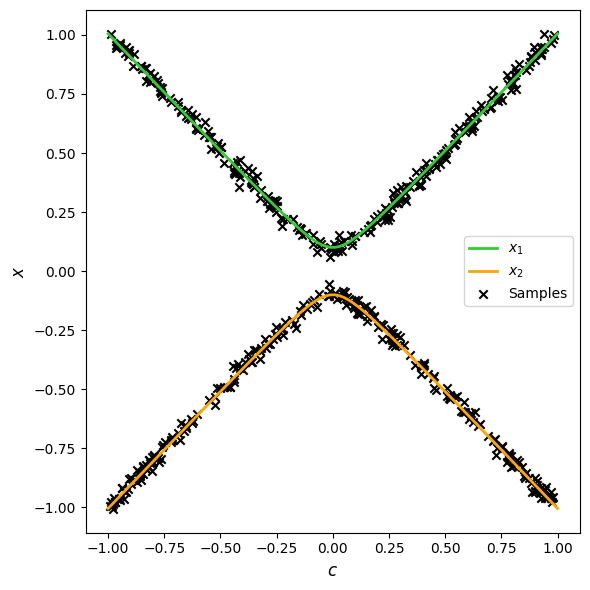

In [4]:
# Apply the rand_mod function to y_circle
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

# # If we want not conflicting data
# num_samples = 500
# x = np.random.uniform(-1, 1, num_samples)
# y = np.array([y_multi(x_i)[0] for x_i in x])

print(x.shape == y.shape)

# Load dataset
batch_size = 32
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

# Generate the global test set
test_x_vals = np.linspace(-1, 1, 100)  # Fixed test x values
test_y_vals = [y_multi(x_i) for x_i in test_x_vals]  # Corresponding true y values
test_y_vals_transposed = list(zip(*test_y_vals))  # Transpose for mode comparison

# Data bounds for counter-sample generation
y_min = torch.tensor([-1])  # Joint y_target limits (radians)
y_max = torch.tensor([1])

# Plot the function and the samples
plt.figure(figsize=(6, 6))
colors = ['limegreen', 'orange']  # Colors for the two modes

for i, (y_val, color) in enumerate(zip(y_vals_transposed, colors)):
    plt.plot(x_vals, y_val, color=color, label=f'$x_{i+1}$', linewidth=2)

plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('$c$', fontsize=12)
plt.ylabel('$x$', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save the figure as a high-resolution image
plt.savefig('2d_geometric_shapes.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

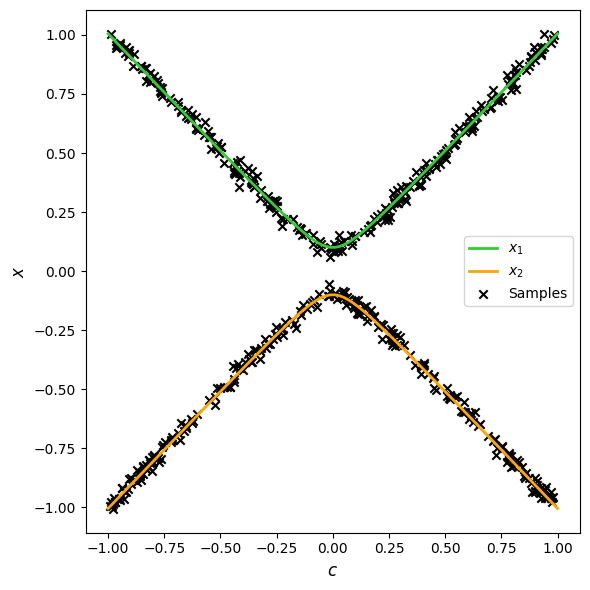

In [5]:
plt.figure(figsize=(6, 6))
colors = ['limegreen', 'orange']  # Colors for the two modes

for i, (test_y_vals, color) in enumerate(zip(test_y_vals_transposed, colors)):
    plt.plot(test_x_vals, test_y_vals, color=color, label=f'$x_{i+1}$', linewidth=2)

plt.scatter(x,y, marker='x', color='black', label='Samples')
plt.xlabel('$c$', fontsize=12)
plt.ylabel('$x$', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save the figure as a high-resolution image
plt.savefig('2d_geometric_shapes.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Evaluation metrics

In [6]:
from scipy.stats import entropy, wasserstein_distance
import random
from methods.ibc import ebm_infer

def compute_metrics(generator, x_test, test_y_vals, y_func, K, model = 'Sampling', num_bins=50, tolerance=0.075, device="cpu"):
    """
    Compute mode coverage, KL divergence, and Wasserstein distance for test data.

    Args:
        generator (torch.nn.Module): The trained generator model.
        x_test (np.array): Input test values.
        test_y_vals (np.array): True y values for the test set (precomputed).
        y_func (function): Function to compute true modes for each x.
        K (int): Number of samples to generate per x.
        num_bins (int): Number of bins for histogram-based metrics.
        tolerance (float): Tolerance for mode matching.
        device (str): Device for computation.

    Returns:
        metrics (dict): Contains mode coverage, KL divergence, and Wasserstein distance.
    """
    # Step 1: Evaluate Mode Coverage and Generate Representative Test Set
    num_inputs = len(x_test)
    avg_modes_cov = 0
    num_modes_covered = 0
    generated_test_y_vals = []  # Store representative generated samples

    for i, x in enumerate(x_test):
        
        # Compute true modes for this x dynamically
        true_modes = np.array(y_func(x))
        
        if model == 'Network':
            # Predict K samples for this x
            x_tensor = torch.tensor([[x]], dtype=torch.float32).repeat(K, 1).to(device)

            generated_samples = generator.forward(x_tensor).detach().cpu().numpy().flatten()
        
        elif model == 'Sampling':
            # Sample K samples for this x
            x_tensor = torch.tensor([[x]], dtype=torch.float32).repeat(K, 1).to(device)
            z = torch.randn(K, generator.latent_size, dtype=torch.float32).to(device)

            generated_samples = generator.sample(z, x_tensor).detach().cpu().numpy().flatten()
        
        elif model == 'Generator':
            # Generate K samples for this x
            x_tensor = torch.tensor([[x]], dtype=torch.float32).repeat(K, 1).to(device)
            z = torch.randn(K, generator.latent_size, dtype=torch.float32).to(device)

            generated_samples = generator.forward(z, x_tensor).detach().cpu().numpy().flatten()
            
        elif model == 'IBC':
            generated_samples = []
            for i in range(K):
                x_tensor = torch.tensor([[x]], dtype=torch.float32).to(device)
                prediction = ebm_infer(generator, x_tensor, y_min.to(device), y_max.to(device))
                generated_samples.append(prediction)
        
        # Check if all true modes are matched within tolerance
        mode_match = [np.any(np.abs(generated_samples - mode) <= tolerance) for mode in true_modes]

        if sum(mode_match) == len(true_modes):  # All modes covered
            num_modes_covered +=  1
        avg_modes_cov +=  sum(mode_match)

        # Append one representative sample for each x to build generated_test_y_vals
        generated_test_y_vals.append(random.choice(generated_samples))  # Representative sample
            

    # Compute mode coverage
    mode_coverage = num_modes_covered / num_inputs *100 
    avg_modes_coverage = avg_modes_cov/ num_inputs
    generated_test_y_vals = np.array(generated_test_y_vals)

    # Step 2: Compute KL Divergence and Wasserstein Distance
    # Flatten test_y_vals and generated_test_y_vals for comparison
    true_y_flat = test_y_vals.flatten()
    generated_y_flat = generated_test_y_vals.flatten()

    # Compute histograms for KL divergence and Wasserstein distance
    hist_true, bins = np.histogram(true_y_flat, bins=num_bins, density=True)
    hist_generated, _ = np.histogram(generated_y_flat, bins=bins, density=True)

    # Smooth histograms to avoid zero probabilities
    hist_true += 1e-8
    hist_generated += 1e-8

    # Normalize histograms
    hist_true /= hist_true.sum()
    hist_generated /= hist_generated.sum()

    # KL Divergence
    kl_div = entropy(hist_true, hist_generated)

    # Wasserstein Distance
    w_distance = wasserstein_distance(hist_true, hist_generated)

    # Return metrics
    return {
        "Mode Coverage (%)": mode_coverage,
        "Avgerage Modes coveraged": avg_modes_coverage,
        "KL Divergence": kl_div,
        "Wasserstein Distance": w_distance,
    }



In [9]:
NUM_TRIALS = 5
TOLERANCE = 0.07

# Problem set-up Parameter


In [10]:
input_size = 1  # x, y x_input
action_size = 1  # joint y_target
condition_size = 1
output_size = 1

# EBGAN-MDN

Hyperparameter

In [11]:
# Hyperparameters
num_gaussians = 2

latent_size = 1
hidden_size = 64

num_epochs = 100
batch_size = 32

neg_count = 32
repeat_energy_updates = 5

learning_rate_e = 0.001
learning_rate_g = 0.0005

epoch_num_eval = 100

# Configuration parameter 
alpha = 1
dynamic_scaling_true = False
min_scale = 0.1

# Tests

In [12]:
# Initialize a new MDN generator
from methods.ebgan import EnergyModel,  generate_counter_samples
from methods.mdn import MDNGenerator, mdn_loss

In [16]:
def evaluate_model(energy_model, generator, epoch, latent_size, device, id = 0):
    # Generate grid points within the range of x values
    x_range = np.linspace(-1, 1, 100)
    y_range = np.linspace(-1, 1, 100)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).to(device)

    # Compute energy model output for each grid point
    energy_outputs = energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()
    energy_outputs = energy_outputs.reshape(100, 100)

    # Normalize every column of the heatmap
    energy_outputs = (energy_outputs - energy_outputs.min(axis=0)) / (energy_outputs.max(axis=0) - energy_outputs.min(axis=0))

    # Plot the heatmap and the function, samples, and predictions in the same figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the heatmap
    heatmap = ax.imshow(energy_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.5)

    # Plot the samples
    ax.scatter(x, y, marker='x', color='black', label='Original samples')

    # Random sample the query points and get the predictions using mdn_generator
    num_query_points = 200
    query_points = np.linspace(-1, 1, num_query_points)
    query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1).to(device)
    z = torch.randn(num_query_points, latent_size).to(device)

    # Generate samples from the mixture model
    predictions_mdn = generator.sample(z, query_points_tensor).detach().cpu().numpy()

    # Plot the MDN generator predictions
    ax.scatter(query_points, predictions_mdn, marker='o', color='red', label='MDN Generator Predictions', alpha=0.9)

    # Set limits to cut the plot within -1, 1
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_xlabel('c')
    ax.set_ylabel('x')
    ax.grid()
    ax.legend()
    # plt.title(f"Evaluation at Epoch {epoch}")
    plt.savefig(f'images/EBM_MDN_{id}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [19]:
from methods.ebgan_mdn import train_ebgan_mdn

def train_and_evaluate(num_trials, dataloader, test_x_vals, test_y_vals_transposed, 
                       num_epochs, y_min, y_max, 
                       neg_count, repeat_energy_updates, device, alpha, dynamic_scaling_true, min_scale, y_multi):
    results = {"KL Divergence": [], "Wasserstein Distance": [], "Mode Coverage (%)": [], "Avgerage Modes coveraged": []}

    for trial in range(num_trials):
        print(f"\n=== Training Run {trial + 1} ===")
        
        ebgan_mdn_generator = MDNGenerator(latent_size, hidden_size, output_size, num_gaussians, condition_size).to(device)
        ebgan_energy_model = EnergyModel(condition_size, output_size, hidden_size).to(device)

        # Optimizer
        optimizer_ebgan_e = optim.Adam(ebgan_energy_model.parameters(), lr=learning_rate_e)
        optimizer_ebgan_g = optim.Adam(ebgan_mdn_generator.parameters(), lr=learning_rate_g)
        scheduler_e = optim.lr_scheduler.StepLR(optimizer_ebgan_e, step_size=20, gamma=0.5)
        scheduler_g = optim.lr_scheduler.StepLR(optimizer_ebgan_g, step_size=20, gamma=0.5)
        
        # Train the model
        train_ebgan_mdn(dataloader, ebgan_energy_model, ebgan_mdn_generator, optimizer_ebgan_e, optimizer_ebgan_g, 
                        scheduler_e, scheduler_g, num_epochs, None, y_min, y_max, neg_count, 
                        repeat_energy_updates, device, alpha, dynamic_scaling_true, min_scale)

        # Flatten the true test y values for metric computation
        true_y_flat = np.array(test_y_vals_transposed).reshape(-1, len(test_x_vals)).T

        # Compute metrics  
        metrics = compute_metrics(ebgan_mdn_generator, test_x_vals, true_y_flat , y_multi, K = 10, num_bins=50, tolerance=TOLERANCE)
        for key in results.keys():
            results[key].append(metrics[key])

        print(f"Run {trial + 1} - KL Divergence: {metrics["KL Divergence"]:.4f}, Wasserstein Distance: {metrics["Wasserstein Distance"]:.4f}, Mode Coverage (%): {metrics["Mode Coverage (%)"]}, Avgerage Modes coveraged: {metrics["Avgerage Modes coveraged"]}")
        
        evaluate_model(ebgan_energy_model, ebgan_mdn_generator, num_epochs, ebgan_mdn_generator.latent_size, device, trial)
    # Compute averages and standard deviations
    for metric, values in results.items():
        avg = np.mean(values)
        std = np.std(values)
        print(f"{metric}: {avg:.4f} ± {std:.4f}")

    return results



=== Training Run 1 ===
Epoch [1/100], Energy Loss: 3.4855, Generator Loss: -0.2730, Generator Energy Loss: -0.4370, Generator MDN Loss: 0.1640
Epoch [2/100], Energy Loss: 3.2779, Generator Loss: -0.7986, Generator Energy Loss: -0.8831, Generator MDN Loss: 0.0845
Epoch [3/100], Energy Loss: 2.9432, Generator Loss: -1.5962, Generator Energy Loss: -1.6251, Generator MDN Loss: 0.0289
Epoch [4/100], Energy Loss: 2.6595, Generator Loss: -1.7514, Generator Energy Loss: -1.7641, Generator MDN Loss: 0.0127
Epoch [5/100], Energy Loss: 2.4640, Generator Loss: -1.7703, Generator Energy Loss: -1.7932, Generator MDN Loss: 0.0228
Epoch [6/100], Energy Loss: 2.3144, Generator Loss: -1.4400, Generator Energy Loss: -1.4666, Generator MDN Loss: 0.0266
Epoch [7/100], Energy Loss: 2.2952, Generator Loss: -1.3317, Generator Energy Loss: -1.3674, Generator MDN Loss: 0.0357
Epoch [8/100], Energy Loss: 2.2057, Generator Loss: -1.1784, Generator Energy Loss: -1.2090, Generator MDN Loss: 0.0307
Epoch [9/100], E

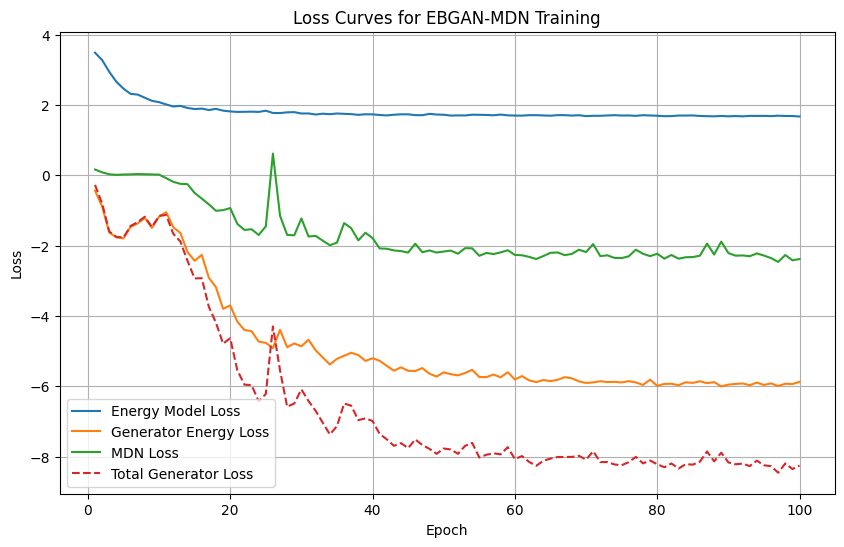

Run 1 - KL Divergence: 1.8591, Wasserstein Distance: 0.0083, Mode Coverage (%): 100.0, Avgerage Modes coveraged: 2.0


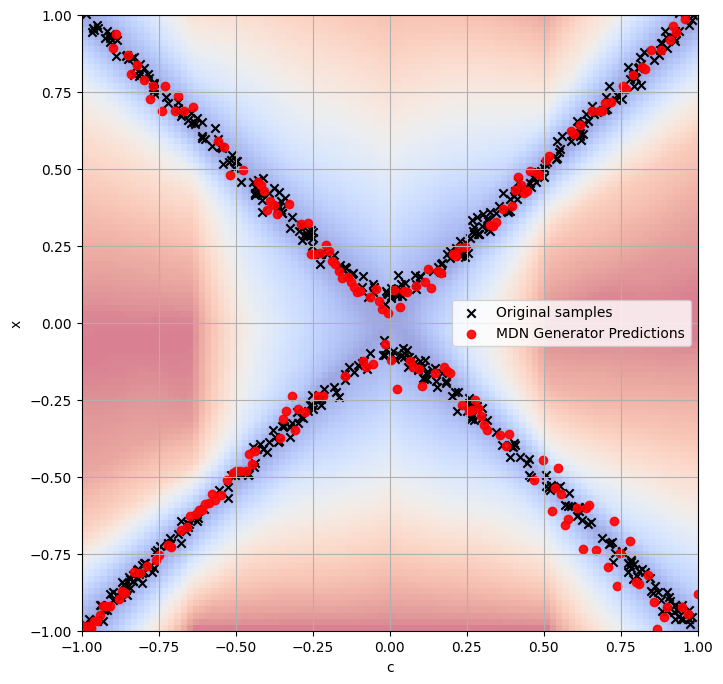


=== Training Run 2 ===
Epoch [1/100], Energy Loss: 3.4673, Generator Loss: 0.2622, Generator Energy Loss: 0.1289, Generator MDN Loss: 0.1333
Epoch [2/100], Energy Loss: 3.2683, Generator Loss: 0.4373, Generator Energy Loss: 0.3886, Generator MDN Loss: 0.0487
Epoch [3/100], Energy Loss: 2.9048, Generator Loss: 1.1364, Generator Energy Loss: 1.1228, Generator MDN Loss: 0.0136
Epoch [4/100], Energy Loss: 2.6466, Generator Loss: 2.2387, Generator Energy Loss: 2.2178, Generator MDN Loss: 0.0210
Epoch [5/100], Energy Loss: 2.4208, Generator Loss: 3.1425, Generator Energy Loss: 3.1352, Generator MDN Loss: 0.0074
Epoch [6/100], Energy Loss: 2.2792, Generator Loss: 3.9917, Generator Energy Loss: 3.9704, Generator MDN Loss: 0.0214
Epoch [7/100], Energy Loss: 2.2132, Generator Loss: 4.4311, Generator Energy Loss: 4.4680, Generator MDN Loss: -0.0370
Epoch [8/100], Energy Loss: 2.0953, Generator Loss: 4.9381, Generator Energy Loss: 5.0941, Generator MDN Loss: -0.1560
Epoch [9/100], Energy Loss: 2.

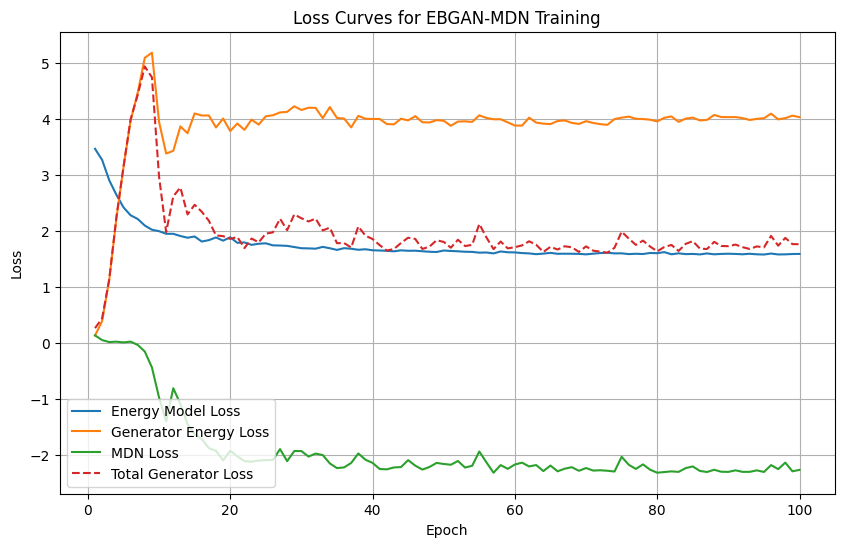

Run 2 - KL Divergence: 2.4195, Wasserstein Distance: 0.0071, Mode Coverage (%): 100.0, Avgerage Modes coveraged: 2.0


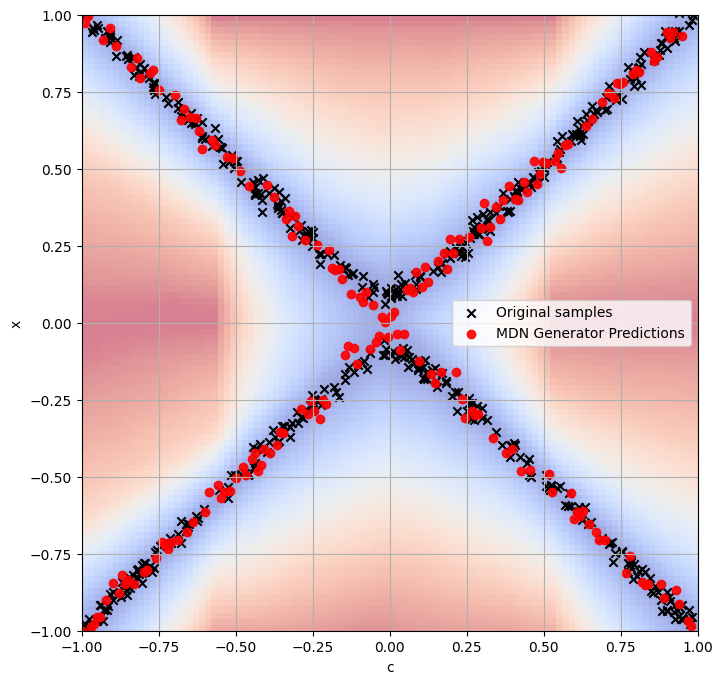


=== Training Run 3 ===
Epoch [1/100], Energy Loss: 3.4775, Generator Loss: 0.1993, Generator Energy Loss: 0.0773, Generator MDN Loss: 0.1220
Epoch [2/100], Energy Loss: 3.2490, Generator Loss: 0.2099, Generator Energy Loss: 0.1544, Generator MDN Loss: 0.0555
Epoch [3/100], Energy Loss: 2.9143, Generator Loss: 0.5811, Generator Energy Loss: 0.5606, Generator MDN Loss: 0.0205
Epoch [4/100], Energy Loss: 2.6200, Generator Loss: 0.7113, Generator Energy Loss: 0.7011, Generator MDN Loss: 0.0102
Epoch [5/100], Energy Loss: 2.4568, Generator Loss: 1.1909, Generator Energy Loss: 1.2142, Generator MDN Loss: -0.0233
Epoch [6/100], Energy Loss: 2.2834, Generator Loss: 1.6717, Generator Energy Loss: 1.6965, Generator MDN Loss: -0.0249
Epoch [7/100], Energy Loss: 2.1829, Generator Loss: 2.1065, Generator Energy Loss: 2.1471, Generator MDN Loss: -0.0405
Epoch [8/100], Energy Loss: 2.0979, Generator Loss: 2.5620, Generator Energy Loss: 2.6229, Generator MDN Loss: -0.0609
Epoch [9/100], Energy Loss: 

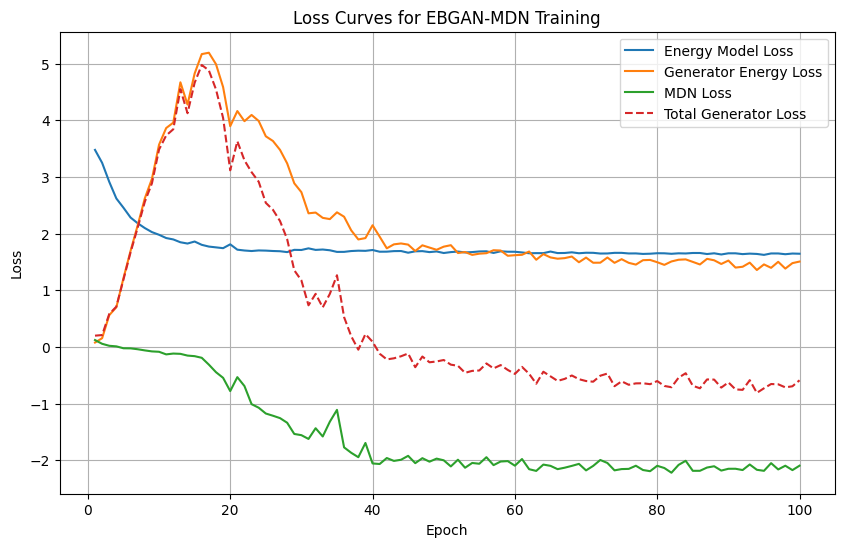

Run 3 - KL Divergence: 2.2253, Wasserstein Distance: 0.0067, Mode Coverage (%): 98.0, Avgerage Modes coveraged: 1.97


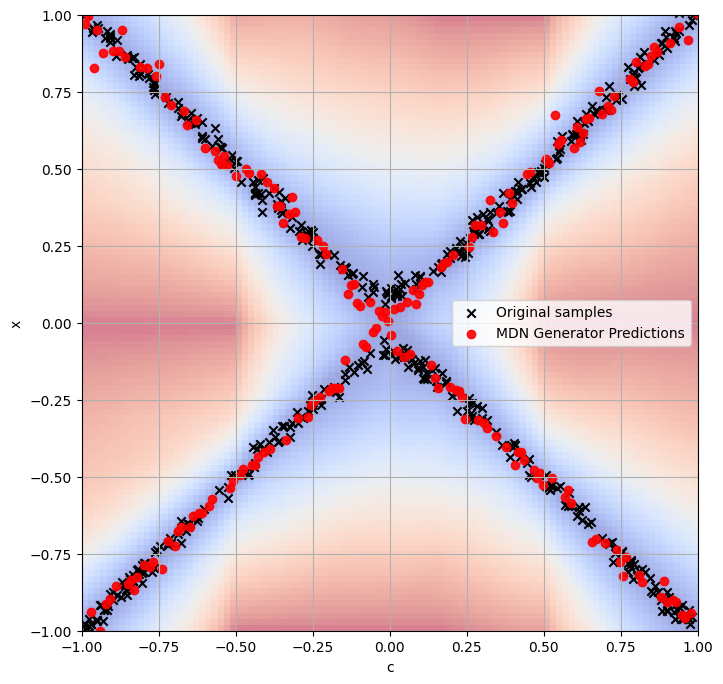


=== Training Run 4 ===
Epoch [1/100], Energy Loss: 3.4836, Generator Loss: 0.0624, Generator Energy Loss: -0.0516, Generator MDN Loss: 0.1140
Epoch [2/100], Energy Loss: 3.3012, Generator Loss: 0.0623, Generator Energy Loss: 0.0284, Generator MDN Loss: 0.0339
Epoch [3/100], Energy Loss: 2.9606, Generator Loss: 0.0944, Generator Energy Loss: 0.0868, Generator MDN Loss: 0.0077
Epoch [4/100], Energy Loss: 2.6415, Generator Loss: 0.2470, Generator Energy Loss: 0.2468, Generator MDN Loss: 0.0002
Epoch [5/100], Energy Loss: 2.4364, Generator Loss: 0.4471, Generator Energy Loss: 0.4556, Generator MDN Loss: -0.0085
Epoch [6/100], Energy Loss: 2.2700, Generator Loss: 0.7240, Generator Energy Loss: 0.7281, Generator MDN Loss: -0.0041
Epoch [7/100], Energy Loss: 2.2038, Generator Loss: 1.4403, Generator Energy Loss: 1.3594, Generator MDN Loss: 0.0809
Epoch [8/100], Energy Loss: 2.0813, Generator Loss: 1.9212, Generator Energy Loss: 1.8779, Generator MDN Loss: 0.0432
Epoch [9/100], Energy Loss: 2

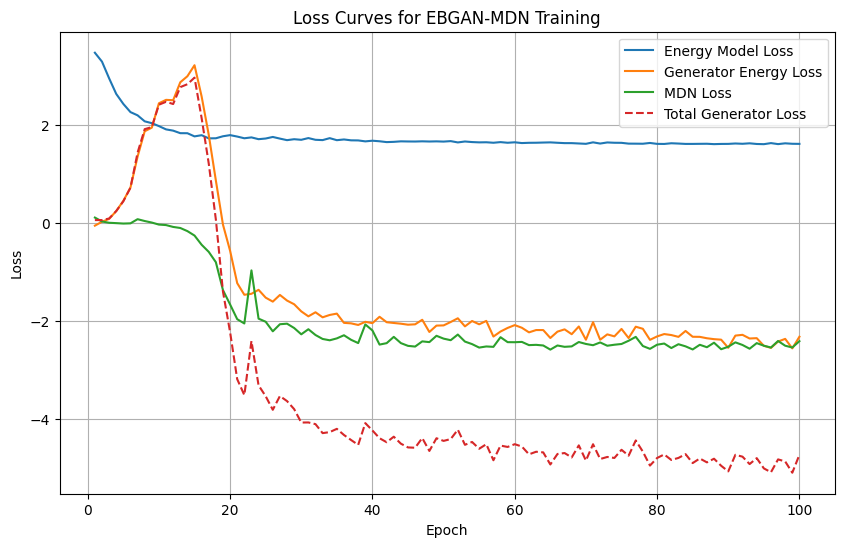

Run 4 - KL Divergence: 1.2922, Wasserstein Distance: 0.0064, Mode Coverage (%): 100.0, Avgerage Modes coveraged: 2.0


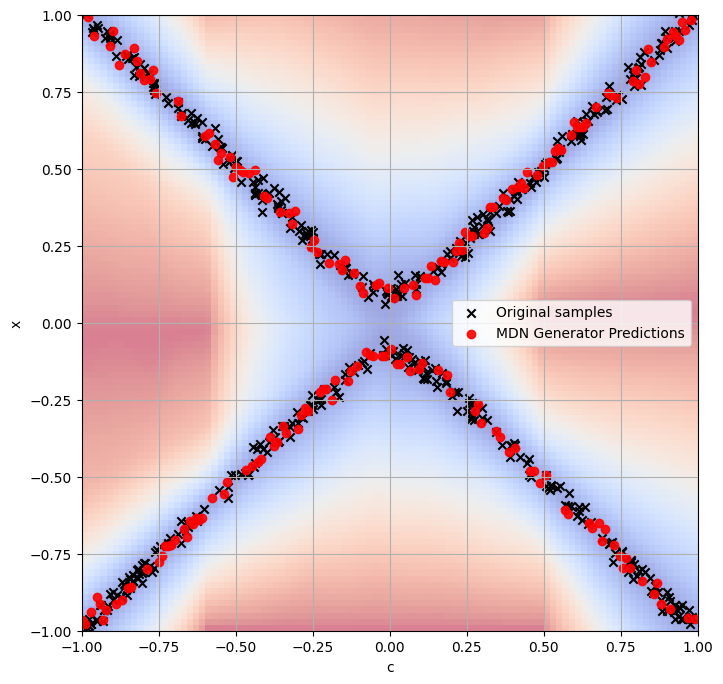


=== Training Run 5 ===
Epoch [1/100], Energy Loss: 3.4603, Generator Loss: 0.3193, Generator Energy Loss: 0.1237, Generator MDN Loss: 0.1957
Epoch [2/100], Energy Loss: 3.1997, Generator Loss: 0.5105, Generator Energy Loss: 0.4484, Generator MDN Loss: 0.0620
Epoch [3/100], Energy Loss: 2.8194, Generator Loss: 1.0193, Generator Energy Loss: 1.0019, Generator MDN Loss: 0.0173
Epoch [4/100], Energy Loss: 2.5225, Generator Loss: 1.7232, Generator Energy Loss: 1.6888, Generator MDN Loss: 0.0344
Epoch [5/100], Energy Loss: 2.3504, Generator Loss: 2.3149, Generator Energy Loss: 2.3288, Generator MDN Loss: -0.0140
Epoch [6/100], Energy Loss: 2.1958, Generator Loss: 2.7196, Generator Energy Loss: 2.7629, Generator MDN Loss: -0.0433
Epoch [7/100], Energy Loss: 2.0929, Generator Loss: 3.1022, Generator Energy Loss: 3.2099, Generator MDN Loss: -0.1077
Epoch [8/100], Energy Loss: 2.0342, Generator Loss: 3.0708, Generator Energy Loss: 3.2852, Generator MDN Loss: -0.2144
Epoch [9/100], Energy Loss: 

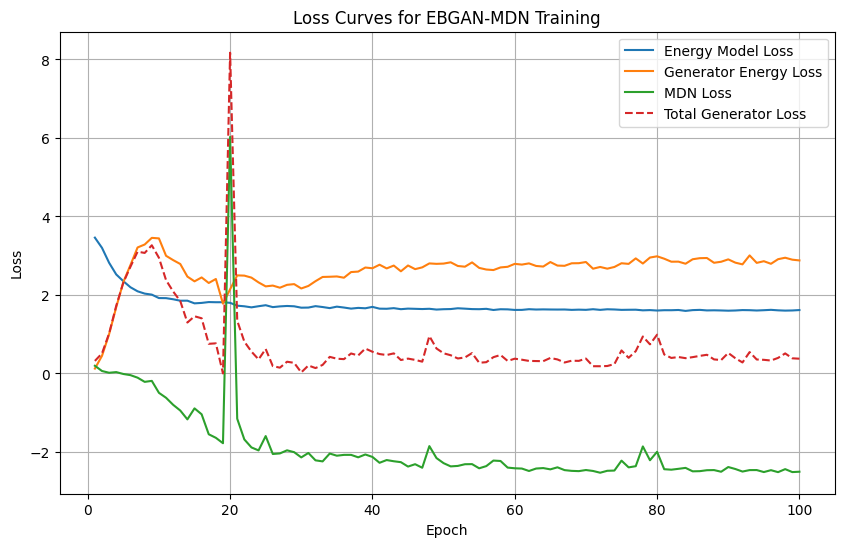

Run 5 - KL Divergence: 1.6656, Wasserstein Distance: 0.0063, Mode Coverage (%): 100.0, Avgerage Modes coveraged: 2.0


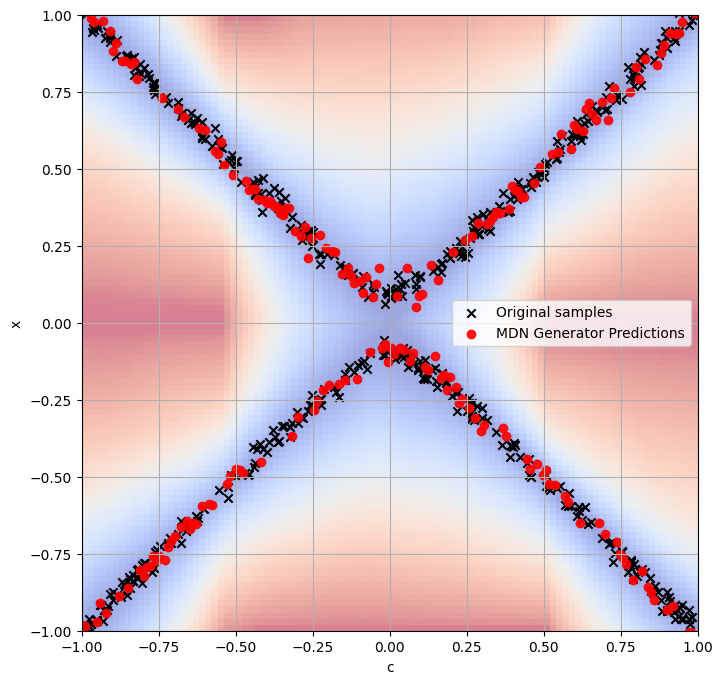

KL Divergence: 1.8923 ± 0.4004
Wasserstein Distance: 0.0070 ± 0.0007
Mode Coverage (%): 99.6000 ± 0.8000
Avgerage Modes coveraged: 1.9940 ± 0.0120


In [20]:
metrics_results = train_and_evaluate(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_min=y_min,
    y_max=y_max,
    neg_count=neg_count,
    repeat_energy_updates=repeat_energy_updates,
    device=device,
    alpha=alpha,
    dynamic_scaling_true=dynamic_scaling_true,
    min_scale=min_scale,
    y_multi = y_multi
)

### Visualization of results and Training progress

Adapting the training loop for visualization

In [14]:
def evaluate_model_clean(energy_model, generator, epoch, latent_size, device, show_energy_map=True, output_path=None):
    """
    Visualize the generator predictions and optionally the energy map.
    
    Args:
        energy_model (torch.nn.Module): The trained energy model.
        generator (torch.nn.Module): The trained generator model.
        epoch (int): Current epoch for visualization.
        latent_size (int): Latent size for the generator.
        device (str): Device to perform computations on.
        show_energy_map (bool): Whether to display the energy map as a background.
        output_path (str): Path to save the figure. If None, displays the figure instead.
    """
    # Generate grid points for the energy map
    if show_energy_map:
        x_range = np.linspace(-1, 1, 100)
        y_range = np.linspace(-1, 1, 100)
        grid_x, grid_y = np.meshgrid(x_range, y_range)
        grid_points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).to(device)

        # Compute energy model output for each grid point
        energy_outputs = energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()
        energy_outputs = energy_outputs.reshape(100, 100)

        # Normalize the heatmap values
        energy_outputs = (energy_outputs - energy_outputs.min(axis=0)) / (energy_outputs.max(axis=0) - energy_outputs.min(axis=0))
    
    # Generate predictions using the generator
    num_query_points = 200
    query_points = np.linspace(-1, 1, num_query_points)
    query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1).to(device)
    z = torch.randn(num_query_points, latent_size).to(device)

    predictions_mdn = generator.sample(z, query_points_tensor).detach().cpu().numpy()

    # Plot the figure
    fig, ax = plt.subplots(figsize=(6, 6))

    if show_energy_map:
        # Plot the energy heatmap
        ax.imshow(
            energy_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.5
        )

    # Plot generator predictions
    ax.scatter(query_points, predictions_mdn, marker='o', color='red', alpha=0.9)

    # Remove axes, borders, and grid for a clean figure
    ax.set_axis_off()

    # Save or display the figure
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight', pad_inches=0)
    else:
        plt.show()

    plt.close(fig)


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import argparse
import os
import shutil
import sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from data_pipeline import RobotDataset
from methods.ebgan_mdn import info_nce_loss, dynamic_scaling

# Training loop combining energy model with MDN generator
def train_ebgan_mdn_with_visualization(dataloader, energy_model, generator, optimizer_e, optimizer_g, 
                    scheduler_e, scheduler_g, num_epochs, writer, 
                    y_min, y_max, neg_count, repeat_energy_updates, device, 
                    alpha = 1, dynamic_scaling_true = False,
                    min_scale = 0.1, epoch_num_eval = 25):
    energy_model.train()
    generator.train()
    # Initialize lists to track losses
    energy_losses = []
    generator_e_losses = []
    mdn_losses = []
    total_g_losses = []

    for epoch in range(num_epochs):
        epoch_e_loss = 0.0
        epoch_g_loss_e = 0.0
        epoch_g_loss_mdn = 0.0
        epoch_g_loss = 0.0
        
        if dynamic_scaling_true:
            alpha = dynamic_scaling(epoch, num_epochs, min_scale)
        
        for batch_x, batch_y in dataloader:
            x_input = batch_x.to(device)
            y_target = batch_y.to(device)

            for _ in range(repeat_energy_updates):
                # Draw noise samples
                z = torch.randn(x_input.size(0), generator.latent_size).to(device)
            
                # Generate fake samples
                fake_y_target = generator.sample(z, x_input)
                
                counter_samples = generate_counter_samples(y_min, y_max, x_input.size(0), neg_count, device)
                
                # Compute loss
                e_loss = info_nce_loss(energy_model, x_input, y_target, counter_samples, fake_y_target, alpha)
                
                # Backpropagation
                optimizer_e.zero_grad()
                e_loss.backward()
                optimizer_e.step()
                
                epoch_e_loss += e_loss.item()

            # Compute energy 
            z = torch.randn(x_input.size(0), generator.latent_size).to(device)
            fake_y_target = generator.sample(z, x_input)
            g_loss_e = energy_model(x_input, fake_y_target).mean()

            # Compute MDN loss
            log_pi, mu, sigma = generator(z, x_input)
            mdn_g_loss = mdn_loss(log_pi, mu, sigma, y_target)

            epoch_g_loss_e += g_loss_e.item()
            epoch_g_loss_mdn += mdn_g_loss.item()
            
            # Combined loss
            g_loss = g_loss_e + mdn_g_loss
            
            epoch_g_loss += g_loss.item()

            # Backpropagation
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()

            # Log losses
            # writer.add_scalar('Loss/EnergyModel', e_loss.item(), epoch * len(dataloader) + i)
            # writer.add_scalar('Loss/GeneratorE', g_loss_e.item(), epoch * len(dataloader) + i)
            # writer.add_scalar('Loss/MDN', mdn_g_loss.item(), epoch * len(dataloader) + i)
            # writer.add_scalar('Loss/Generator', g_loss.item(), epoch * len(dataloader) + i)

        scheduler_e.step()
        scheduler_g.step()
        avg_e_loss = epoch_e_loss / len(dataloader) / repeat_energy_updates
        avg_g_loss_e = epoch_g_loss_e / len(dataloader)
        avg_g_loss_mdn = epoch_g_loss_mdn / len(dataloader)
        avg_g_loss = epoch_g_loss / len(dataloader)
        
        # Store losses for plotting
        energy_losses.append(avg_e_loss)
        generator_e_losses.append(avg_g_loss_e)
        mdn_losses.append(avg_g_loss_mdn)
        total_g_losses.append(avg_g_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
                f"Energy Loss: {avg_e_loss:.4f}, "
                f"Generator Loss: {avg_g_loss:.4f}, "
                f"Generator Energy Loss: {avg_g_loss_e:.4f}, "
                f"Generator MDN Loss: {avg_g_loss_mdn:.4f}"
                )
        
        # Evaluate model every 20 epochs
        if (epoch + 1) % epoch_num_eval == 0:
            evaluate_model(energy_model, generator, epoch + 1, generator.latent_size, device)
            evaluate_model_clean(
                energy_model=energy_model,
                generator=generator,
                epoch=epoch + 1,
                latent_size=generator.latent_size,
                device=device,
                show_energy_map=False,
                output_path=None
            )
        
    # Plot the loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), energy_losses, label='Energy Model Loss')
    plt.plot(range(1, num_epochs + 1), generator_e_losses, label='Generator Energy Loss')
    plt.plot(range(1, num_epochs + 1), mdn_losses, label='MDN Loss')
    plt.plot(range(1, num_epochs + 1), total_g_losses, label='Total Generator Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves for EBGAN-MDN Training')
    plt.legend()
    plt.grid(True)
    plt.show()

In [19]:
ebgan_mdn_generator = MDNGenerator(latent_size, hidden_size, output_size, num_gaussians, condition_size).to(device)
ebgan_energy_model = EnergyModel(condition_size, output_size, hidden_size).to(device)

# Optimizer
optimizer_ebgan_e = optim.Adam(ebgan_energy_model.parameters(), lr=learning_rate_e)
optimizer_ebgan_g = optim.Adam(ebgan_mdn_generator.parameters(), lr=learning_rate_g)
scheduler_e = optim.lr_scheduler.StepLR(optimizer_ebgan_e, step_size=20, gamma=0.5)
scheduler_g = optim.lr_scheduler.StepLR(optimizer_ebgan_g, step_size=20, gamma=0.5)


In [ ]:
epoch_num_eval = 10

Epoch [1/100], Energy Loss: 3.4849, Generator Loss: 0.0593, Generator Energy Loss: -0.0674, Generator MDN Loss: 0.1267
Epoch [2/100], Energy Loss: 3.2880, Generator Loss: -0.1011, Generator Energy Loss: -0.1439, Generator MDN Loss: 0.0428
Epoch [3/100], Energy Loss: 2.9636, Generator Loss: -0.2496, Generator Energy Loss: -0.2650, Generator MDN Loss: 0.0154
Epoch [4/100], Energy Loss: 2.7001, Generator Loss: -0.1842, Generator Energy Loss: -0.2023, Generator MDN Loss: 0.0181
Epoch [5/100], Energy Loss: 2.4670, Generator Loss: 0.1411, Generator Energy Loss: 0.1474, Generator MDN Loss: -0.0063
Epoch [6/100], Energy Loss: 2.3207, Generator Loss: 0.5677, Generator Energy Loss: 0.5821, Generator MDN Loss: -0.0144
Epoch [7/100], Energy Loss: 2.1975, Generator Loss: 0.8559, Generator Energy Loss: 0.8832, Generator MDN Loss: -0.0273
Epoch [8/100], Energy Loss: 2.0907, Generator Loss: 1.2618, Generator Energy Loss: 1.2929, Generator MDN Loss: -0.0311
Epoch [9/100], Energy Loss: 2.0261, Generator

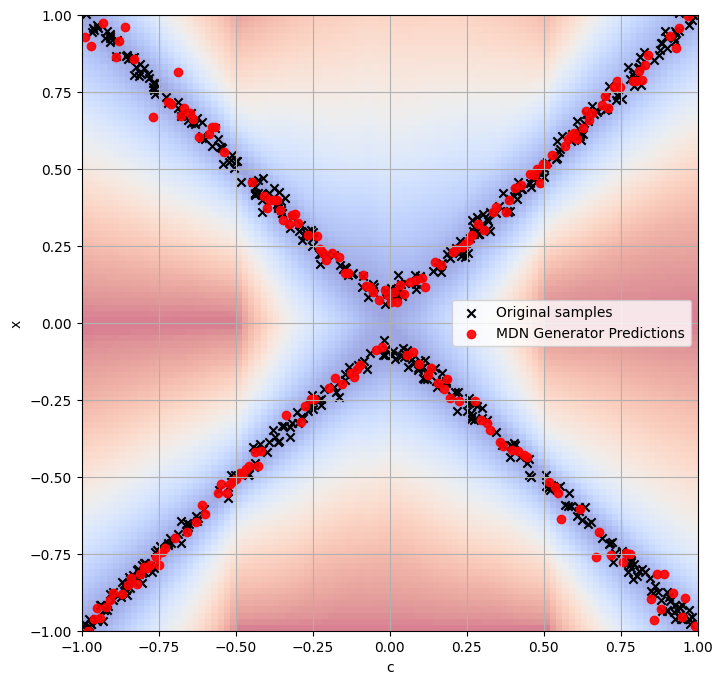

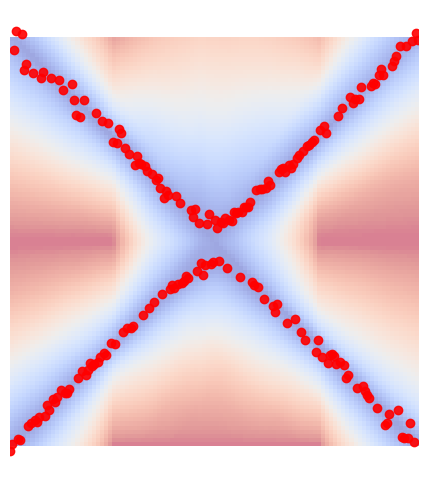

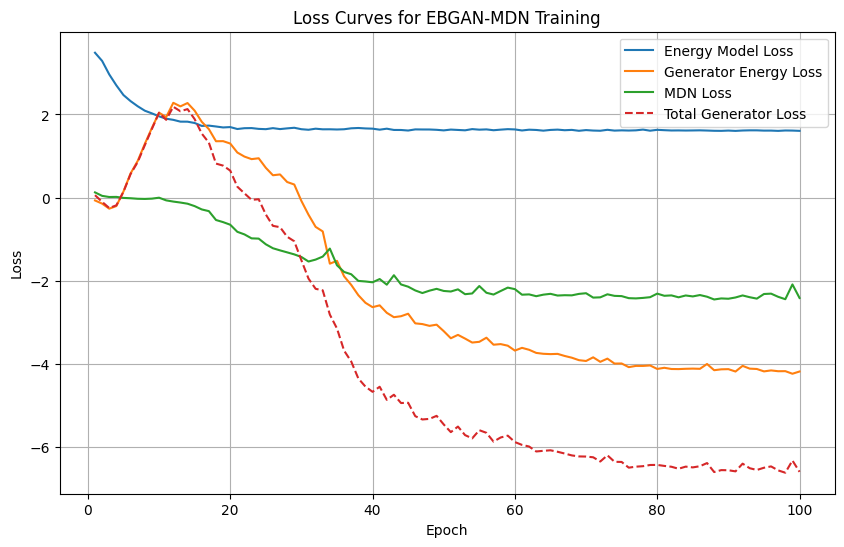

In [20]:
train_ebgan_mdn_with_visualization(dataloader, ebgan_energy_model, ebgan_mdn_generator, optimizer_ebgan_e, optimizer_ebgan_g, 
                    scheduler_e, scheduler_g, num_epochs, None,
                    y_min, y_max, neg_count, repeat_energy_updates, device, 
                    alpha, dynamic_scaling_true,
                    min_scale, epoch_num_eval)

# Other models

## 1. Explicit BC

In [21]:
# Hyperparameters

hidden_size = 64

num_epochs = 100
batch_size = 32
learning_rate = 0.001

In [22]:

def visulize_outcomes(mlp, y_multi, id = 0):
    # Random sample the query points and get the predictions
    num_query_points = 100
    query_points = np.linspace(-1, 1, num_query_points)
    query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1)
    predictions = mlp(query_points_tensor).detach().numpy()

    # Plot the function, samples, and predictions
    x_vals = np.linspace(-1, 1, 100)
    y_vals = [y_multi(x_i) for x_i in x_vals]
    y_vals_transposed = list(zip(*y_vals))

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot the true functions
    colors = ['limegreen', 'orange']  # Colors for the two modes

    # for i, (y_val, color) in enumerate(zip(y_vals_transposed, colors)):
    #     plt.plot(x_vals, y_val, color=color, label=f'Target {i+1}: $y_{i+1}(x)$', linewidth=2)
    
    # Plot samples and predictions
    ax.scatter(x, y, marker='x', color='black', label='Original Samples')
    ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.9)
    
    # Remove grid
    ax.grid(False)
    
    # Set labels and legend
    ax.set_xlabel('c')
    ax.set_ylabel('x')
    ax.legend(loc='center left', bbox_to_anchor=(0.77, 0.55))
    
    # Show or save the plot
    plt.savefig(f'images/Explicit_BC_{id}.png', dpi=300, bbox_inches='tight')
    plt.show()


In [23]:
from methods.mlp import MLP, train
def train_and_evaluate_nn(num_trials, dataloader, test_x_vals, test_y_vals_transposed, 
                       num_epochs, y_multi, learning_rate, hidden_size):
    results = {"KL Divergence": [], "Wasserstein Distance": [], "Mode Coverage (%)": [], "Avgerage Modes coveraged": []}

    for trial in range(num_trials):
        print(f"\n=== Training Run {trial + 1} ===")
        
        mlp = MLP(input_size, hidden_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
        
        # Train the model
        train(mlp, dataloader, criterion, optimizer, scheduler, num_epochs, writer = None)

        # Flatten the true test y values for metric computation
        true_y_flat = np.array(test_y_vals_transposed).reshape(-1, len(test_x_vals)).T

        # Compute metrics  
        metrics = compute_metrics(mlp, test_x_vals, true_y_flat , y_multi, model =  'Network', K = 10, num_bins=50, tolerance=TOLERANCE)
        for key in results.keys():
            results[key].append(metrics[key])
            
        print(f"Run {trial + 1} - KL Divergence: {metrics["KL Divergence"]:.4f}, Wasserstein Distance: {metrics["Wasserstein Distance"]:.4f}, Mode Coverage (%): {metrics["Mode Coverage (%)"]}, Avgerage Modes coveraged: {metrics["Avgerage Modes coveraged"]}")
        visulize_outcomes(mlp, y_multi, trial)
        
        
    # Compute averages and standard deviations
    for metric, values in results.items():
        avg = np.mean(values)
        std = np.std(values)
        print(f"{metric}: {avg:.4f} ± {std:.4f}")

    return results

### Tests 


=== Training Run 1 ===
Epoch [1/100], Loss: 0.3698, LR: 0.001000
Epoch [2/100], Loss: 0.3679, LR: 0.001000
Epoch [3/100], Loss: 0.3652, LR: 0.001000
Epoch [4/100], Loss: 0.3638, LR: 0.001000
Epoch [5/100], Loss: 0.3611, LR: 0.001000
Epoch [6/100], Loss: 0.3674, LR: 0.001000
Epoch [7/100], Loss: 0.3609, LR: 0.001000
Epoch [8/100], Loss: 0.3613, LR: 0.001000
Epoch [9/100], Loss: 0.3629, LR: 0.001000
Epoch [10/100], Loss: 0.3591, LR: 0.001000
Epoch [11/100], Loss: 0.3599, LR: 0.001000
Epoch [12/100], Loss: 0.3590, LR: 0.001000
Epoch [13/100], Loss: 0.3580, LR: 0.001000
Epoch [14/100], Loss: 0.3615, LR: 0.001000
Epoch [15/100], Loss: 0.3601, LR: 0.001000
Epoch [16/100], Loss: 0.3588, LR: 0.001000
Epoch [17/100], Loss: 0.3538, LR: 0.001000
Epoch [18/100], Loss: 0.3579, LR: 0.001000
Epoch [19/100], Loss: 0.3568, LR: 0.001000
Epoch [20/100], Loss: 0.3586, LR: 0.000500
Epoch [21/100], Loss: 0.3553, LR: 0.000500
Epoch [22/100], Loss: 0.3511, LR: 0.000500
Epoch [23/100], Loss: 0.3531, LR: 0.000

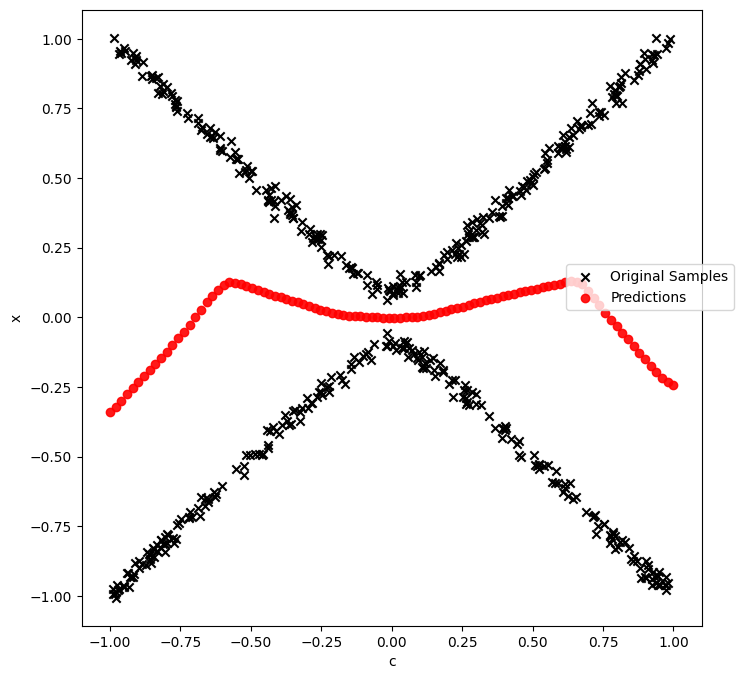


=== Training Run 2 ===
Epoch [1/100], Loss: 0.3659, LR: 0.001000
Epoch [2/100], Loss: 0.3642, LR: 0.001000
Epoch [3/100], Loss: 0.3617, LR: 0.001000
Epoch [4/100], Loss: 0.3660, LR: 0.001000
Epoch [5/100], Loss: 0.3637, LR: 0.001000
Epoch [6/100], Loss: 0.3611, LR: 0.001000
Epoch [7/100], Loss: 0.3649, LR: 0.001000
Epoch [8/100], Loss: 0.3606, LR: 0.001000
Epoch [9/100], Loss: 0.3582, LR: 0.001000
Epoch [10/100], Loss: 0.3621, LR: 0.001000
Epoch [11/100], Loss: 0.3577, LR: 0.001000
Epoch [12/100], Loss: 0.3607, LR: 0.001000
Epoch [13/100], Loss: 0.3574, LR: 0.001000
Epoch [14/100], Loss: 0.3579, LR: 0.001000
Epoch [15/100], Loss: 0.3542, LR: 0.001000
Epoch [16/100], Loss: 0.3597, LR: 0.001000
Epoch [17/100], Loss: 0.3610, LR: 0.001000
Epoch [18/100], Loss: 0.3555, LR: 0.001000
Epoch [19/100], Loss: 0.3568, LR: 0.001000
Epoch [20/100], Loss: 0.3563, LR: 0.000500
Epoch [21/100], Loss: 0.3518, LR: 0.000500
Epoch [22/100], Loss: 0.3546, LR: 0.000500
Epoch [23/100], Loss: 0.3520, LR: 0.000

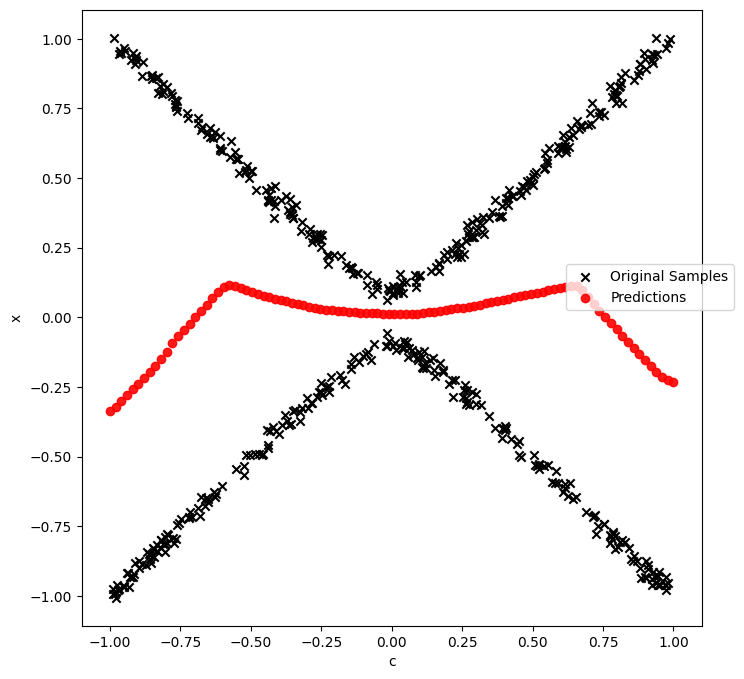


=== Training Run 3 ===
Epoch [1/100], Loss: 0.3720, LR: 0.001000
Epoch [2/100], Loss: 0.3648, LR: 0.001000
Epoch [3/100], Loss: 0.3604, LR: 0.001000
Epoch [4/100], Loss: 0.3640, LR: 0.001000
Epoch [5/100], Loss: 0.3627, LR: 0.001000
Epoch [6/100], Loss: 0.3626, LR: 0.001000
Epoch [7/100], Loss: 0.3639, LR: 0.001000
Epoch [8/100], Loss: 0.3635, LR: 0.001000
Epoch [9/100], Loss: 0.3607, LR: 0.001000
Epoch [10/100], Loss: 0.3606, LR: 0.001000
Epoch [11/100], Loss: 0.3623, LR: 0.001000
Epoch [12/100], Loss: 0.3620, LR: 0.001000
Epoch [13/100], Loss: 0.3597, LR: 0.001000
Epoch [14/100], Loss: 0.3583, LR: 0.001000
Epoch [15/100], Loss: 0.3570, LR: 0.001000
Epoch [16/100], Loss: 0.3582, LR: 0.001000
Epoch [17/100], Loss: 0.3604, LR: 0.001000
Epoch [18/100], Loss: 0.3544, LR: 0.001000
Epoch [19/100], Loss: 0.3567, LR: 0.001000
Epoch [20/100], Loss: 0.3581, LR: 0.000500
Epoch [21/100], Loss: 0.3531, LR: 0.000500
Epoch [22/100], Loss: 0.3577, LR: 0.000500
Epoch [23/100], Loss: 0.3580, LR: 0.000

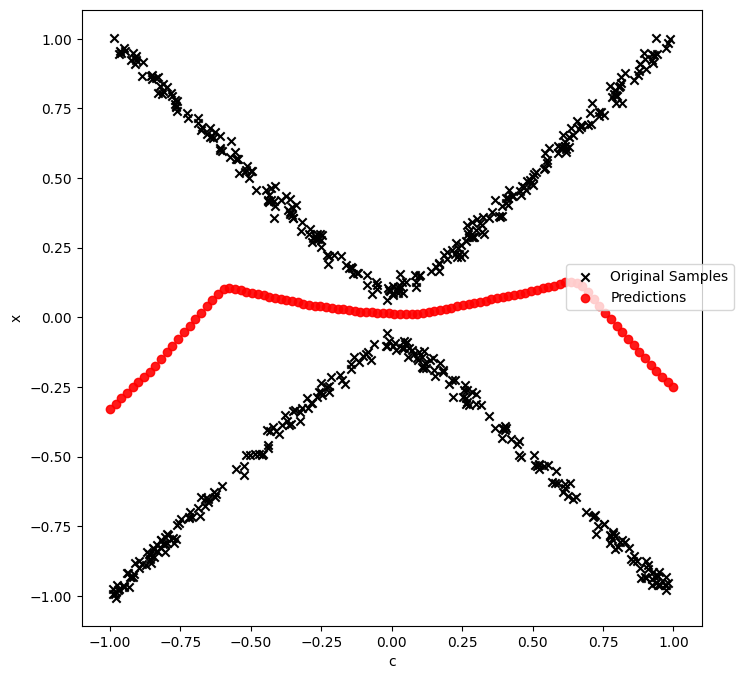


=== Training Run 4 ===
Epoch [1/100], Loss: 0.3691, LR: 0.001000
Epoch [2/100], Loss: 0.3662, LR: 0.001000
Epoch [3/100], Loss: 0.3648, LR: 0.001000
Epoch [4/100], Loss: 0.3632, LR: 0.001000
Epoch [5/100], Loss: 0.3611, LR: 0.001000
Epoch [6/100], Loss: 0.3626, LR: 0.001000
Epoch [7/100], Loss: 0.3622, LR: 0.001000
Epoch [8/100], Loss: 0.3622, LR: 0.001000
Epoch [9/100], Loss: 0.3600, LR: 0.001000
Epoch [10/100], Loss: 0.3569, LR: 0.001000
Epoch [11/100], Loss: 0.3602, LR: 0.001000
Epoch [12/100], Loss: 0.3559, LR: 0.001000
Epoch [13/100], Loss: 0.3572, LR: 0.001000
Epoch [14/100], Loss: 0.3555, LR: 0.001000
Epoch [15/100], Loss: 0.3553, LR: 0.001000
Epoch [16/100], Loss: 0.3553, LR: 0.001000
Epoch [17/100], Loss: 0.3567, LR: 0.001000
Epoch [18/100], Loss: 0.3525, LR: 0.001000
Epoch [19/100], Loss: 0.3590, LR: 0.001000
Epoch [20/100], Loss: 0.3528, LR: 0.000500
Epoch [21/100], Loss: 0.3551, LR: 0.000500
Epoch [22/100], Loss: 0.3529, LR: 0.000500
Epoch [23/100], Loss: 0.3524, LR: 0.000

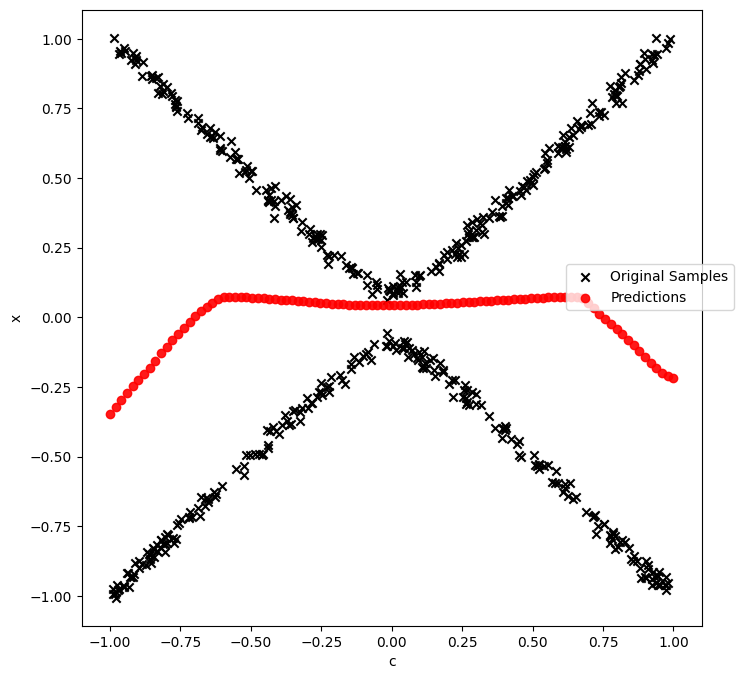


=== Training Run 5 ===
Epoch [1/100], Loss: 0.3706, LR: 0.001000
Epoch [2/100], Loss: 0.3643, LR: 0.001000
Epoch [3/100], Loss: 0.3656, LR: 0.001000
Epoch [4/100], Loss: 0.3621, LR: 0.001000
Epoch [5/100], Loss: 0.3604, LR: 0.001000
Epoch [6/100], Loss: 0.3619, LR: 0.001000
Epoch [7/100], Loss: 0.3592, LR: 0.001000
Epoch [8/100], Loss: 0.3629, LR: 0.001000
Epoch [9/100], Loss: 0.3581, LR: 0.001000
Epoch [10/100], Loss: 0.3598, LR: 0.001000
Epoch [11/100], Loss: 0.3576, LR: 0.001000
Epoch [12/100], Loss: 0.3559, LR: 0.001000
Epoch [13/100], Loss: 0.3581, LR: 0.001000
Epoch [14/100], Loss: 0.3562, LR: 0.001000
Epoch [15/100], Loss: 0.3606, LR: 0.001000
Epoch [16/100], Loss: 0.3583, LR: 0.001000
Epoch [17/100], Loss: 0.3563, LR: 0.001000
Epoch [18/100], Loss: 0.3582, LR: 0.001000
Epoch [19/100], Loss: 0.3564, LR: 0.001000
Epoch [20/100], Loss: 0.3544, LR: 0.000500
Epoch [21/100], Loss: 0.3520, LR: 0.000500
Epoch [22/100], Loss: 0.3534, LR: 0.000500
Epoch [23/100], Loss: 0.3572, LR: 0.000

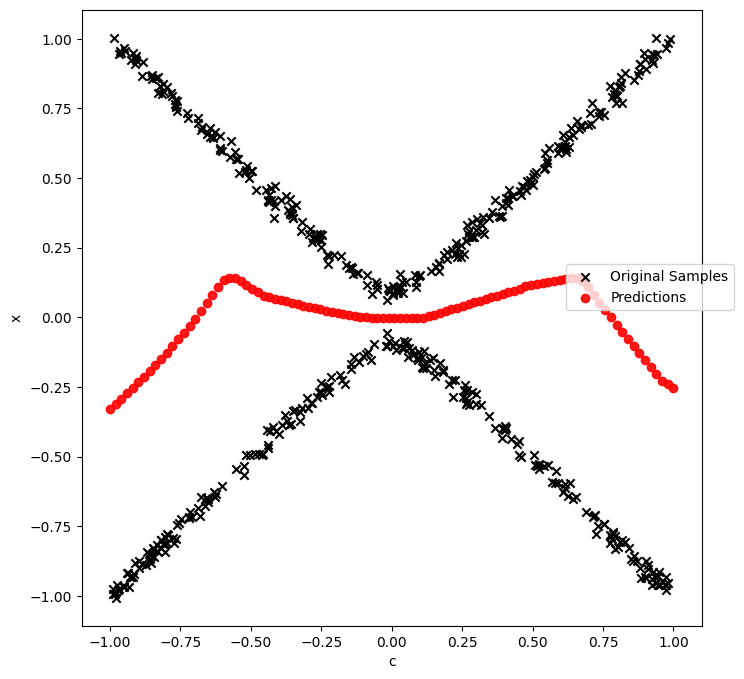

KL Divergence: 13.9400 ± 0.4553
Wasserstein Distance: 0.0273 ± 0.0006
Mode Coverage (%): 0.0000 ± 0.0000
Avgerage Modes coveraged: 0.0120 ± 0.0240


In [24]:
metrics_results = train_and_evaluate_nn(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_multi = y_multi,
    learning_rate = learning_rate,
    hidden_size = hidden_size
)

## 2. MDN

In [25]:
# Hyperparameters

hidden_size = 64
num_gaussians = 2
num_epochs = 100
batch_size = 32
learning_rate = 0.001

In [33]:
def visulize_outcomes_mdn(mdn, y_multi, id= 0):
    """
    Visualize the MDN predictions against the true multi-valued function with slightly messy samples.

    Args:
        mdn (torch.nn.Module): Trained MDN model.
        y_multi (function): Multi-valued function generating the true y values.
    """
    # Generate query points and MDN predictions
    num_query_points = 100
    query_points = np.linspace(-1, 1, num_query_points)
    query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1).to(device)
    
    # Generate predictions using the MDN
    z = torch.randn(num_query_points, mdn.latent_size).to(device)
    predictions_mdn = mdn.sample(z, query_points_tensor).detach().cpu().numpy()

    # Generate the true function values and add slight noise for "messy" appearance
    x_vals = np.linspace(-1, 1, 100)
    y_vals = [y_multi(x_i) for x_i in x_vals]
    y_vals_transposed = list(zip(*y_vals))


    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot the true functions
    # colors = ['limegreen', 'orange']  # Colors for the two modes
    # for i, (y_val, color) in enumerate(zip(y_vals_transposed, colors)):
    #     ax.plot(x_vals, y_val, color=color, label=f'Target {i+1}: $y_{i+1}(x)$', linewidth=2)
    
    # Plot noisy true samples and generated predictions
    ax.scatter(x, y, marker='x', color='black', label='Original Samples')
    ax.scatter(query_points, predictions_mdn, marker='o', color='red', label='Predictions', alpha=0.9)
    
    # Remove grid
    ax.grid(False)
    
    # Set labels and legend
    ax.set_xlabel('c')
    ax.set_ylabel('x')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.legend(loc='center left', bbox_to_anchor=(0.77, 0.55))
    
    # Show the plot
    plt.savefig(f'images/MDN_G3_{id}.png', dpi=300, bbox_inches='tight')
    plt.show()


In [27]:
from methods.mdn import MDNGenerator, train, mdn_loss
def train_and_evaluate_mdn(num_trials, dataloader, test_x_vals, test_y_vals_transposed, 
                       num_epochs, y_multi, learning_rate, num_gaussians, hidden_size):
    results = {"KL Divergence": [], "Wasserstein Distance": [], "Mode Coverage (%)": [], "Avgerage Modes coveraged": []}

    for trial in range(num_trials):
        print(f"\n=== Training Run {trial + 1} ===")
        
        model = MDNGenerator(input_size, hidden_size, output_size, num_gaussians, condition_size)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
        
        # Train
        train(model, dataloader, mdn_loss, optimizer, scheduler, num_epochs, None, device)

        # Flatten the true test y values for metric computation
        true_y_flat = np.array(test_y_vals_transposed).reshape(-1, len(test_x_vals)).T

        # Compute metrics 
        metrics = compute_metrics(model, test_x_vals, true_y_flat , y_multi, model = 'Sampling', K = 10, num_bins=50, tolerance=TOLERANCE)
        for key in results.keys():
            results[key].append(metrics[key])
            
        print(f"Run {trial + 1} - KL Divergence: {metrics["KL Divergence"]:.4f}, Wasserstein Distance: {metrics["Wasserstein Distance"]:.4f}, Mode Coverage (%): {metrics["Mode Coverage (%)"]}, Avgerage Modes coveraged: {metrics["Avgerage Modes coveraged"]}")
        visulize_outcomes_mdn(model, y_multi, trial)
        
    # Compute averages and standard deviations
    for metric, values in results.items():
        avg = np.mean(values)
        std = np.std(values)
        print(f"{metric}: {avg:.4f} ± {std:.4f}")

    return results

### Tests


=== Training Run 1 ===
Epoch [1/100], Loss: 0.0556, LR: 0.001000
Epoch [2/100], Loss: 0.0079, LR: 0.001000
Epoch [3/100], Loss: -0.0504, LR: 0.001000
Epoch [4/100], Loss: -0.1731, LR: 0.001000
Epoch [5/100], Loss: -0.3443, LR: 0.001000
Epoch [6/100], Loss: -0.6232, LR: 0.001000
Epoch [7/100], Loss: -1.0620, LR: 0.001000
Epoch [8/100], Loss: -1.4054, LR: 0.001000
Epoch [9/100], Loss: -1.6780, LR: 0.001000
Epoch [10/100], Loss: -1.7007, LR: 0.001000
Epoch [11/100], Loss: -1.9252, LR: 0.001000
Epoch [12/100], Loss: -2.0298, LR: 0.001000
Epoch [13/100], Loss: -1.4219, LR: 0.001000
Epoch [14/100], Loss: -1.7594, LR: 0.001000
Epoch [15/100], Loss: -2.0337, LR: 0.001000
Epoch [16/100], Loss: -2.2817, LR: 0.001000
Epoch [17/100], Loss: -2.1755, LR: 0.001000
Epoch [18/100], Loss: -2.2701, LR: 0.001000
Epoch [19/100], Loss: -2.3224, LR: 0.001000
Epoch [20/100], Loss: -2.4070, LR: 0.000500
Epoch [21/100], Loss: -2.4027, LR: 0.000500
Epoch [22/100], Loss: -2.4767, LR: 0.000500
Epoch [23/100], Los

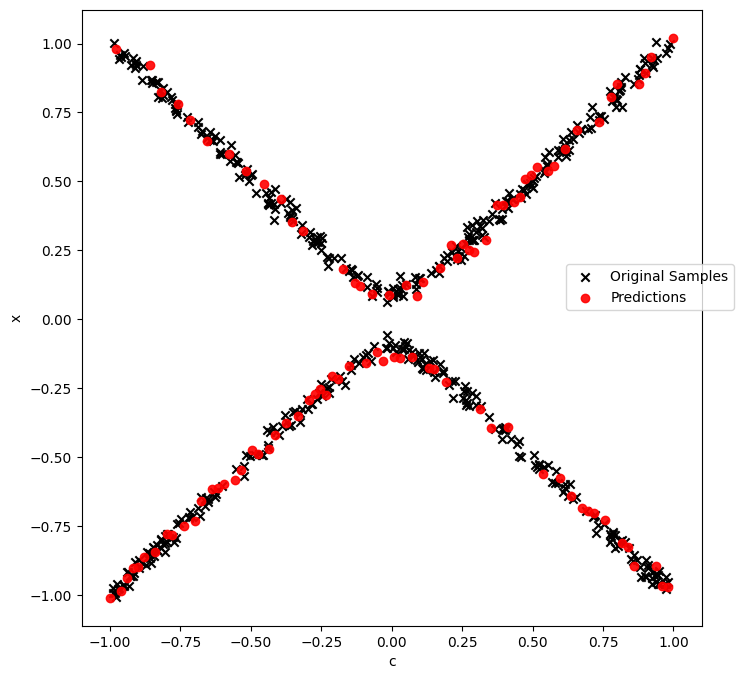


=== Training Run 2 ===
Epoch [1/100], Loss: 0.0802, LR: 0.001000
Epoch [2/100], Loss: 0.0099, LR: 0.001000
Epoch [3/100], Loss: 0.0006, LR: 0.001000
Epoch [4/100], Loss: -0.0400, LR: 0.001000
Epoch [5/100], Loss: -0.1012, LR: 0.001000
Epoch [6/100], Loss: -0.2792, LR: 0.001000
Epoch [7/100], Loss: -0.6078, LR: 0.001000
Epoch [8/100], Loss: -1.0009, LR: 0.001000
Epoch [9/100], Loss: -1.2340, LR: 0.001000
Epoch [10/100], Loss: -1.3885, LR: 0.001000
Epoch [11/100], Loss: -1.6299, LR: 0.001000
Epoch [12/100], Loss: -1.9893, LR: 0.001000
Epoch [13/100], Loss: -1.7796, LR: 0.001000
Epoch [14/100], Loss: -1.9250, LR: 0.001000
Epoch [15/100], Loss: -2.1751, LR: 0.001000
Epoch [16/100], Loss: -2.0955, LR: 0.001000
Epoch [17/100], Loss: -2.3162, LR: 0.001000
Epoch [18/100], Loss: -2.3561, LR: 0.001000
Epoch [19/100], Loss: -1.8808, LR: 0.001000
Epoch [20/100], Loss: -2.0758, LR: 0.000500
Epoch [21/100], Loss: -2.2339, LR: 0.000500
Epoch [22/100], Loss: -2.3869, LR: 0.000500
Epoch [23/100], Loss

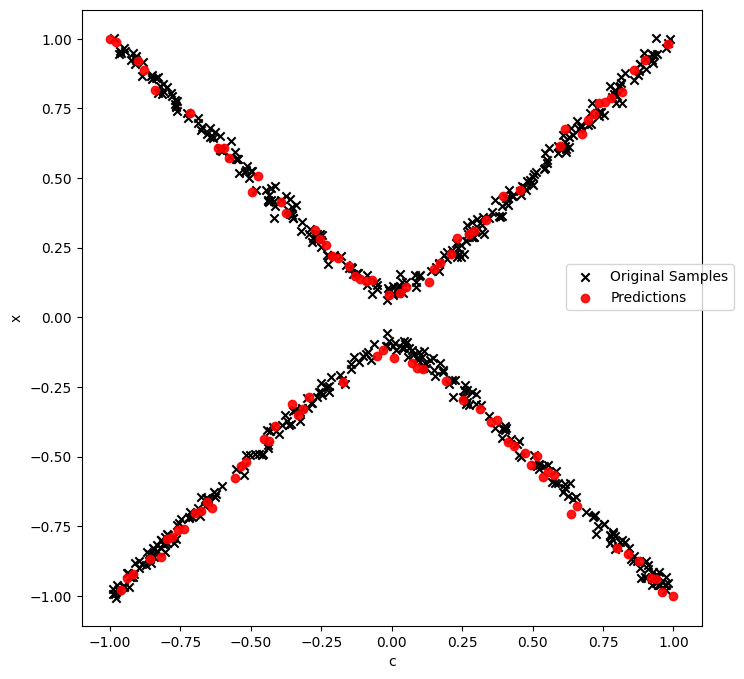


=== Training Run 3 ===
Epoch [1/100], Loss: 0.0539, LR: 0.001000
Epoch [2/100], Loss: -0.0147, LR: 0.001000
Epoch [3/100], Loss: -0.0434, LR: 0.001000
Epoch [4/100], Loss: -0.1273, LR: 0.001000
Epoch [5/100], Loss: -0.2915, LR: 0.001000
Epoch [6/100], Loss: -0.4481, LR: 0.001000
Epoch [7/100], Loss: -0.6779, LR: 0.001000
Epoch [8/100], Loss: -0.5648, LR: 0.001000
Epoch [9/100], Loss: -0.6866, LR: 0.001000
Epoch [10/100], Loss: -0.8774, LR: 0.001000
Epoch [11/100], Loss: -0.8931, LR: 0.001000
Epoch [12/100], Loss: -0.8040, LR: 0.001000
Epoch [13/100], Loss: -1.0673, LR: 0.001000
Epoch [14/100], Loss: -1.2747, LR: 0.001000
Epoch [15/100], Loss: -0.9858, LR: 0.001000
Epoch [16/100], Loss: -1.5628, LR: 0.001000
Epoch [17/100], Loss: -1.8248, LR: 0.001000
Epoch [18/100], Loss: -1.7524, LR: 0.001000
Epoch [19/100], Loss: -1.7153, LR: 0.001000
Epoch [20/100], Loss: -1.9137, LR: 0.000500
Epoch [21/100], Loss: -2.1146, LR: 0.000500
Epoch [22/100], Loss: -2.1556, LR: 0.000500
Epoch [23/100], Lo

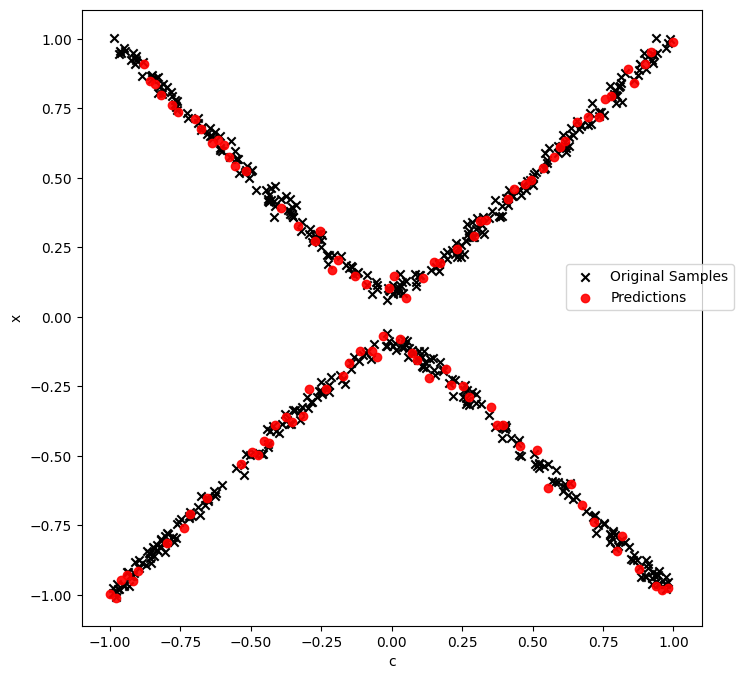


=== Training Run 4 ===
Epoch [1/100], Loss: 0.1404, LR: 0.001000
Epoch [2/100], Loss: 0.0310, LR: 0.001000
Epoch [3/100], Loss: -0.0018, LR: 0.001000
Epoch [4/100], Loss: -0.0366, LR: 0.001000
Epoch [5/100], Loss: -0.1345, LR: 0.001000
Epoch [6/100], Loss: -0.3669, LR: 0.001000
Epoch [7/100], Loss: -0.7122, LR: 0.001000
Epoch [8/100], Loss: -0.6909, LR: 0.001000
Epoch [9/100], Loss: -0.7757, LR: 0.001000
Epoch [10/100], Loss: -0.9080, LR: 0.001000
Epoch [11/100], Loss: -0.7716, LR: 0.001000
Epoch [12/100], Loss: -0.8410, LR: 0.001000
Epoch [13/100], Loss: -0.9886, LR: 0.001000
Epoch [14/100], Loss: -1.0778, LR: 0.001000
Epoch [15/100], Loss: -1.0132, LR: 0.001000
Epoch [16/100], Loss: -1.0431, LR: 0.001000
Epoch [17/100], Loss: -1.0938, LR: 0.001000
Epoch [18/100], Loss: -1.1702, LR: 0.001000
Epoch [19/100], Loss: -1.1848, LR: 0.001000
Epoch [20/100], Loss: -1.2033, LR: 0.000500
Epoch [21/100], Loss: -1.2329, LR: 0.000500
Epoch [22/100], Loss: -1.1776, LR: 0.000500
Epoch [23/100], Los

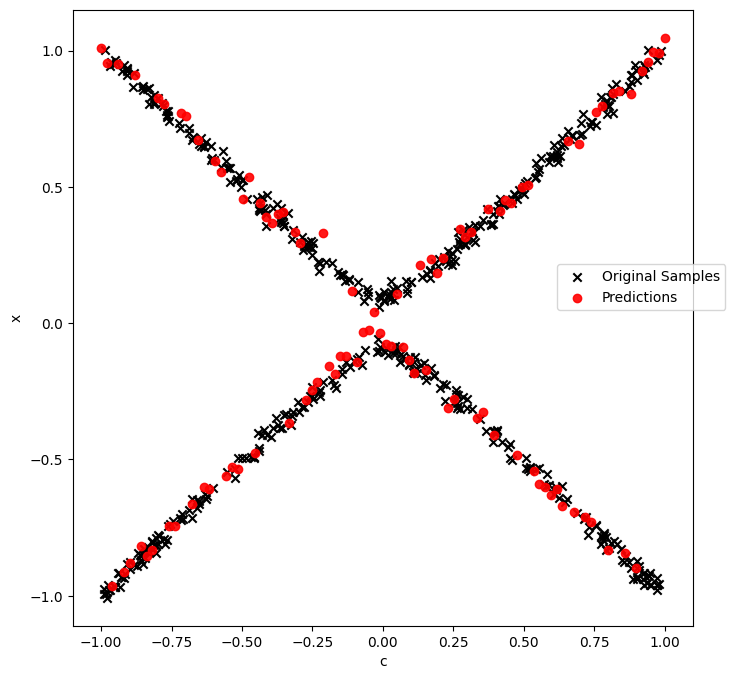


=== Training Run 5 ===
Epoch [1/100], Loss: 0.1168, LR: 0.001000
Epoch [2/100], Loss: 0.0145, LR: 0.001000
Epoch [3/100], Loss: -0.0224, LR: 0.001000
Epoch [4/100], Loss: -0.0695, LR: 0.001000
Epoch [5/100], Loss: -0.1961, LR: 0.001000
Epoch [6/100], Loss: -0.3238, LR: 0.001000
Epoch [7/100], Loss: -0.6739, LR: 0.001000
Epoch [8/100], Loss: -1.1517, LR: 0.001000
Epoch [9/100], Loss: -1.3921, LR: 0.001000
Epoch [10/100], Loss: -1.7374, LR: 0.001000
Epoch [11/100], Loss: -1.9245, LR: 0.001000
Epoch [12/100], Loss: -1.6606, LR: 0.001000
Epoch [13/100], Loss: -1.8291, LR: 0.001000
Epoch [14/100], Loss: -2.0615, LR: 0.001000
Epoch [15/100], Loss: -2.2621, LR: 0.001000
Epoch [16/100], Loss: -2.2503, LR: 0.001000
Epoch [17/100], Loss: -2.3450, LR: 0.001000
Epoch [18/100], Loss: -2.2166, LR: 0.001000
Epoch [19/100], Loss: -2.3388, LR: 0.001000
Epoch [20/100], Loss: -2.3258, LR: 0.000500
Epoch [21/100], Loss: -2.4522, LR: 0.000500
Epoch [22/100], Loss: -2.5000, LR: 0.000500
Epoch [23/100], Los

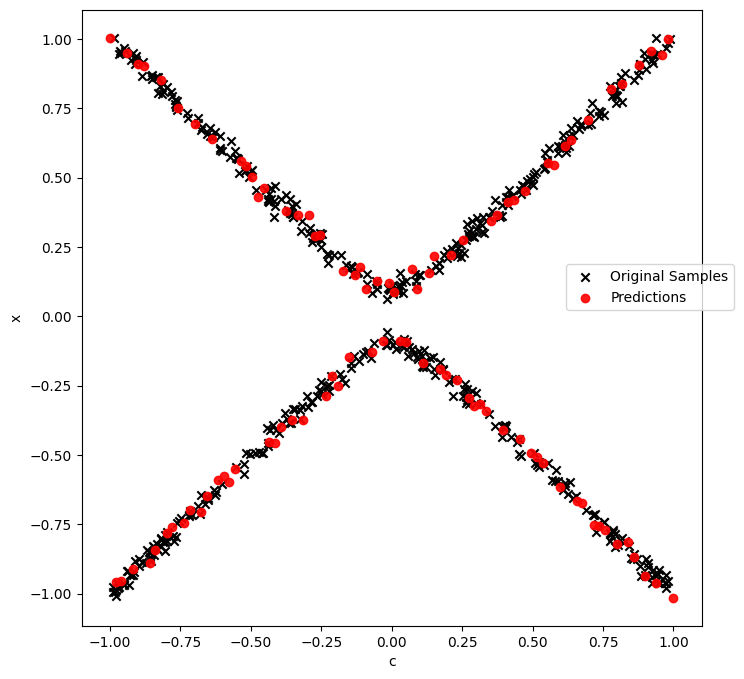

KL Divergence: 1.5790 ± 1.0683
Wasserstein Distance: 0.0069 ± 0.0014
Mode Coverage (%): 99.8000 ± 0.4000
Avgerage Modes coveraged: 1.9980 ± 0.0040


In [28]:
metrics_results = train_and_evaluate_mdn(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_multi = y_multi,
    learning_rate = learning_rate,
    num_gaussians = num_gaussians,
    hidden_size = hidden_size
)


=== Training Run 1 ===
Epoch [1/100], Loss: 0.0794, LR: 0.001000
Epoch [2/100], Loss: -0.0031, LR: 0.001000
Epoch [3/100], Loss: -0.0246, LR: 0.001000
Epoch [4/100], Loss: -0.0390, LR: 0.001000
Epoch [5/100], Loss: -0.0567, LR: 0.001000
Epoch [6/100], Loss: -0.0909, LR: 0.001000
Epoch [7/100], Loss: -0.1155, LR: 0.001000
Epoch [8/100], Loss: -0.1487, LR: 0.001000
Epoch [9/100], Loss: -0.1894, LR: 0.001000
Epoch [10/100], Loss: -0.2205, LR: 0.001000
Epoch [11/100], Loss: -0.2351, LR: 0.001000
Epoch [12/100], Loss: -0.2496, LR: 0.001000
Epoch [13/100], Loss: -0.2708, LR: 0.001000
Epoch [14/100], Loss: -0.2645, LR: 0.001000
Epoch [15/100], Loss: -0.2749, LR: 0.001000
Epoch [16/100], Loss: -0.2705, LR: 0.001000
Epoch [17/100], Loss: -0.2761, LR: 0.001000
Epoch [18/100], Loss: -0.2786, LR: 0.001000
Epoch [19/100], Loss: -0.2663, LR: 0.001000
Epoch [20/100], Loss: -0.2702, LR: 0.000500
Epoch [21/100], Loss: -0.2883, LR: 0.000500
Epoch [22/100], Loss: -0.2841, LR: 0.000500
Epoch [23/100], Lo

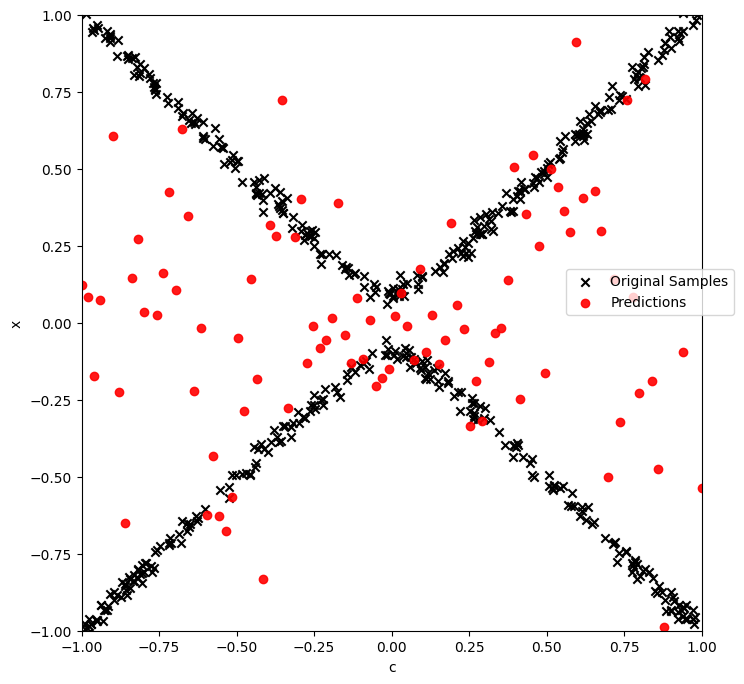


=== Training Run 2 ===
Epoch [1/100], Loss: 0.1092, LR: 0.001000
Epoch [2/100], Loss: 0.0276, LR: 0.001000
Epoch [3/100], Loss: 0.0065, LR: 0.001000
Epoch [4/100], Loss: -0.0262, LR: 0.001000
Epoch [5/100], Loss: -0.0564, LR: 0.001000
Epoch [6/100], Loss: -0.0857, LR: 0.001000
Epoch [7/100], Loss: -0.1311, LR: 0.001000
Epoch [8/100], Loss: -0.1712, LR: 0.001000
Epoch [9/100], Loss: -0.2069, LR: 0.001000
Epoch [10/100], Loss: -0.2272, LR: 0.001000
Epoch [11/100], Loss: -0.2455, LR: 0.001000
Epoch [12/100], Loss: -0.2599, LR: 0.001000
Epoch [13/100], Loss: -0.2720, LR: 0.001000
Epoch [14/100], Loss: -0.2713, LR: 0.001000
Epoch [15/100], Loss: -0.2697, LR: 0.001000
Epoch [16/100], Loss: -0.2681, LR: 0.001000
Epoch [17/100], Loss: -0.2722, LR: 0.001000
Epoch [18/100], Loss: -0.2723, LR: 0.001000
Epoch [19/100], Loss: -0.2828, LR: 0.001000
Epoch [20/100], Loss: -0.2819, LR: 0.000500
Epoch [21/100], Loss: -0.2821, LR: 0.000500
Epoch [22/100], Loss: -0.2801, LR: 0.000500
Epoch [23/100], Loss

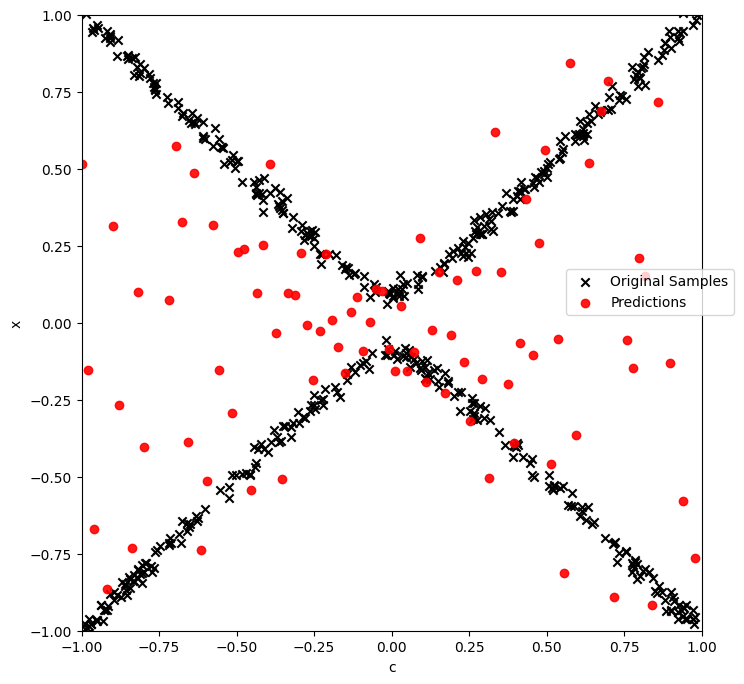


=== Training Run 3 ===
Epoch [1/100], Loss: 0.0370, LR: 0.001000
Epoch [2/100], Loss: -0.0066, LR: 0.001000
Epoch [3/100], Loss: -0.0397, LR: 0.001000
Epoch [4/100], Loss: -0.0758, LR: 0.001000
Epoch [5/100], Loss: -0.1179, LR: 0.001000
Epoch [6/100], Loss: -0.1664, LR: 0.001000
Epoch [7/100], Loss: -0.2103, LR: 0.001000
Epoch [8/100], Loss: -0.2395, LR: 0.001000
Epoch [9/100], Loss: -0.2673, LR: 0.001000
Epoch [10/100], Loss: -0.2678, LR: 0.001000
Epoch [11/100], Loss: -0.2708, LR: 0.001000
Epoch [12/100], Loss: -0.2710, LR: 0.001000
Epoch [13/100], Loss: -0.2649, LR: 0.001000
Epoch [14/100], Loss: -0.2685, LR: 0.001000
Epoch [15/100], Loss: -0.2746, LR: 0.001000
Epoch [16/100], Loss: -0.2589, LR: 0.001000
Epoch [17/100], Loss: -0.2860, LR: 0.001000
Epoch [18/100], Loss: -0.2813, LR: 0.001000
Epoch [19/100], Loss: -0.2847, LR: 0.001000
Epoch [20/100], Loss: -0.2889, LR: 0.000500
Epoch [21/100], Loss: -0.2971, LR: 0.000500
Epoch [22/100], Loss: -0.2861, LR: 0.000500
Epoch [23/100], Lo

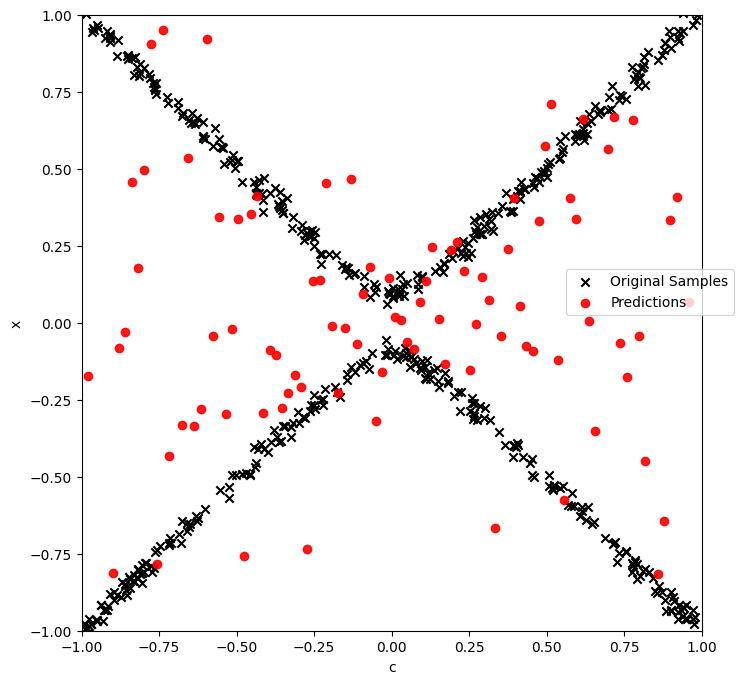


=== Training Run 4 ===
Epoch [1/100], Loss: 0.0638, LR: 0.001000
Epoch [2/100], Loss: -0.0011, LR: 0.001000
Epoch [3/100], Loss: -0.0235, LR: 0.001000
Epoch [4/100], Loss: -0.0526, LR: 0.001000
Epoch [5/100], Loss: -0.0976, LR: 0.001000
Epoch [6/100], Loss: -0.1536, LR: 0.001000
Epoch [7/100], Loss: -0.1936, LR: 0.001000
Epoch [8/100], Loss: -0.2303, LR: 0.001000
Epoch [9/100], Loss: -0.2528, LR: 0.001000
Epoch [10/100], Loss: -0.2653, LR: 0.001000
Epoch [11/100], Loss: -0.2710, LR: 0.001000
Epoch [12/100], Loss: -0.2723, LR: 0.001000
Epoch [13/100], Loss: -0.2835, LR: 0.001000
Epoch [14/100], Loss: -0.2737, LR: 0.001000
Epoch [15/100], Loss: -0.2756, LR: 0.001000
Epoch [16/100], Loss: -0.2777, LR: 0.001000
Epoch [17/100], Loss: -0.2775, LR: 0.001000
Epoch [18/100], Loss: -0.2943, LR: 0.001000
Epoch [19/100], Loss: -0.2828, LR: 0.001000
Epoch [20/100], Loss: -0.2874, LR: 0.000500
Epoch [21/100], Loss: -0.2914, LR: 0.000500
Epoch [22/100], Loss: -0.2904, LR: 0.000500
Epoch [23/100], Lo

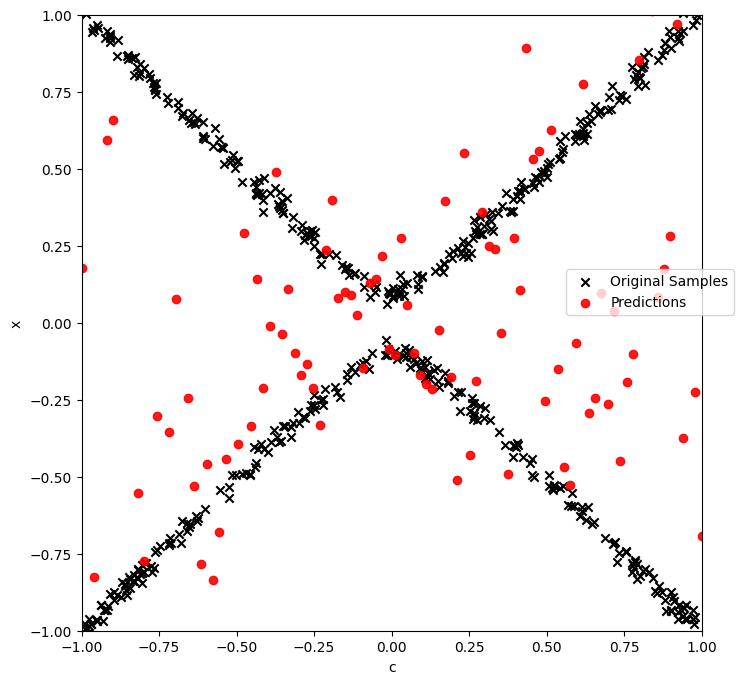


=== Training Run 5 ===
Epoch [1/100], Loss: 0.1025, LR: 0.001000
Epoch [2/100], Loss: 0.0183, LR: 0.001000
Epoch [3/100], Loss: -0.0028, LR: 0.001000
Epoch [4/100], Loss: -0.0306, LR: 0.001000
Epoch [5/100], Loss: -0.0615, LR: 0.001000
Epoch [6/100], Loss: -0.0961, LR: 0.001000
Epoch [7/100], Loss: -0.1398, LR: 0.001000
Epoch [8/100], Loss: -0.1802, LR: 0.001000
Epoch [9/100], Loss: -0.2123, LR: 0.001000
Epoch [10/100], Loss: -0.2399, LR: 0.001000
Epoch [11/100], Loss: -0.2532, LR: 0.001000
Epoch [12/100], Loss: -0.2699, LR: 0.001000
Epoch [13/100], Loss: -0.2649, LR: 0.001000
Epoch [14/100], Loss: -0.2767, LR: 0.001000
Epoch [15/100], Loss: -0.2674, LR: 0.001000
Epoch [16/100], Loss: -0.2757, LR: 0.001000
Epoch [17/100], Loss: -0.2865, LR: 0.001000
Epoch [18/100], Loss: -0.2803, LR: 0.001000
Epoch [19/100], Loss: -0.2808, LR: 0.001000
Epoch [20/100], Loss: -0.2781, LR: 0.000500
Epoch [21/100], Loss: -0.2926, LR: 0.000500
Epoch [22/100], Loss: -0.2871, LR: 0.000500
Epoch [23/100], Los

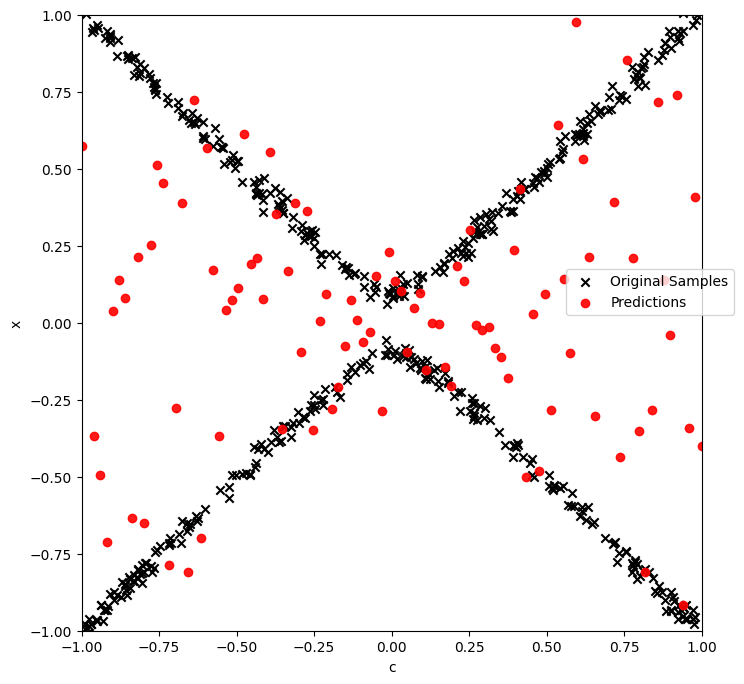

KL Divergence: 4.9112 ± 0.8581
Wasserstein Distance: 0.0127 ± 0.0013
Mode Coverage (%): 35.2000 ± 4.8744
Avgerage Modes coveraged: 1.1180 ± 0.0877


In [32]:
metrics_results = train_and_evaluate_mdn(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_multi = y_multi,
    learning_rate = learning_rate,
    num_gaussians = 1,
    hidden_size = hidden_size
)


=== Training Run 1 ===
Epoch [1/100], Loss: 0.1398, LR: 0.001000
Epoch [2/100], Loss: 0.0402, LR: 0.001000
Epoch [3/100], Loss: 0.0110, LR: 0.001000
Epoch [4/100], Loss: -0.0070, LR: 0.001000
Epoch [5/100], Loss: -0.0329, LR: 0.001000
Epoch [6/100], Loss: -0.0529, LR: 0.001000
Epoch [7/100], Loss: -0.1152, LR: 0.001000
Epoch [8/100], Loss: -0.2302, LR: 0.001000
Epoch [9/100], Loss: -0.4700, LR: 0.001000
Epoch [10/100], Loss: -0.8644, LR: 0.001000
Epoch [11/100], Loss: -1.3834, LR: 0.001000
Epoch [12/100], Loss: -1.7651, LR: 0.001000
Epoch [13/100], Loss: -1.8081, LR: 0.001000
Epoch [14/100], Loss: -1.9232, LR: 0.001000
Epoch [15/100], Loss: -2.0112, LR: 0.001000
Epoch [16/100], Loss: -2.1115, LR: 0.001000
Epoch [17/100], Loss: -2.2314, LR: 0.001000
Epoch [18/100], Loss: -2.3294, LR: 0.001000
Epoch [19/100], Loss: -2.1780, LR: 0.001000
Epoch [20/100], Loss: -2.2843, LR: 0.000500
Epoch [21/100], Loss: -2.4094, LR: 0.000500
Epoch [22/100], Loss: -2.4708, LR: 0.000500
Epoch [23/100], Loss

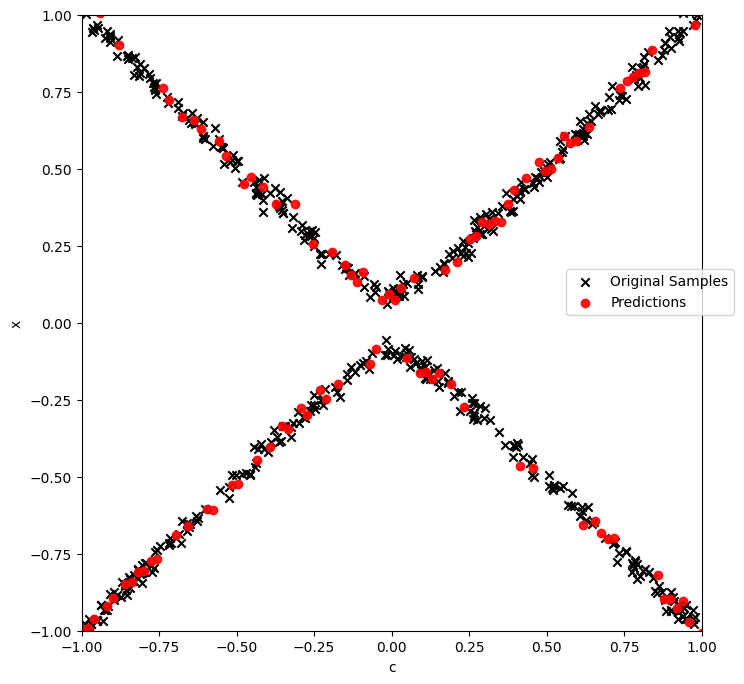


=== Training Run 2 ===
Epoch [1/100], Loss: 0.1124, LR: 0.001000
Epoch [2/100], Loss: 0.0133, LR: 0.001000
Epoch [3/100], Loss: -0.0038, LR: 0.001000
Epoch [4/100], Loss: -0.0247, LR: 0.001000
Epoch [5/100], Loss: -0.0490, LR: 0.001000
Epoch [6/100], Loss: -0.0934, LR: 0.001000
Epoch [7/100], Loss: -0.1420, LR: 0.001000
Epoch [8/100], Loss: -0.2239, LR: 0.001000
Epoch [9/100], Loss: -0.5067, LR: 0.001000
Epoch [10/100], Loss: -0.8479, LR: 0.001000
Epoch [11/100], Loss: -1.3927, LR: 0.001000
Epoch [12/100], Loss: -1.4649, LR: 0.001000
Epoch [13/100], Loss: -1.6497, LR: 0.001000
Epoch [14/100], Loss: -1.8233, LR: 0.001000
Epoch [15/100], Loss: -2.0044, LR: 0.001000
Epoch [16/100], Loss: -2.1765, LR: 0.001000
Epoch [17/100], Loss: -2.1926, LR: 0.001000
Epoch [18/100], Loss: -2.1658, LR: 0.001000
Epoch [19/100], Loss: -2.1945, LR: 0.001000
Epoch [20/100], Loss: -2.2452, LR: 0.000500
Epoch [21/100], Loss: -2.3749, LR: 0.000500
Epoch [22/100], Loss: -2.4838, LR: 0.000500
Epoch [23/100], Los

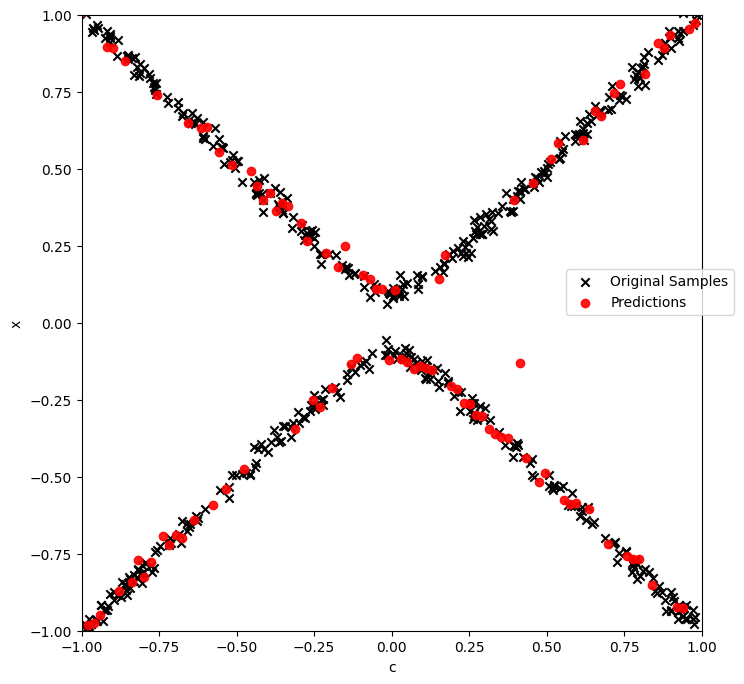


=== Training Run 3 ===
Epoch [1/100], Loss: 0.1037, LR: 0.001000
Epoch [2/100], Loss: 0.0135, LR: 0.001000
Epoch [3/100], Loss: -0.0013, LR: 0.001000
Epoch [4/100], Loss: -0.0252, LR: 0.001000
Epoch [5/100], Loss: -0.0765, LR: 0.001000
Epoch [6/100], Loss: -0.2180, LR: 0.001000
Epoch [7/100], Loss: -0.6056, LR: 0.001000
Epoch [8/100], Loss: -1.1614, LR: 0.001000
Epoch [9/100], Loss: -1.1503, LR: 0.001000
Epoch [10/100], Loss: -1.5670, LR: 0.001000
Epoch [11/100], Loss: -1.7999, LR: 0.001000
Epoch [12/100], Loss: -1.7165, LR: 0.001000
Epoch [13/100], Loss: -1.8800, LR: 0.001000
Epoch [14/100], Loss: -1.9951, LR: 0.001000
Epoch [15/100], Loss: -1.8624, LR: 0.001000
Epoch [16/100], Loss: -2.0656, LR: 0.001000
Epoch [17/100], Loss: -2.1389, LR: 0.001000
Epoch [18/100], Loss: -1.8945, LR: 0.001000
Epoch [19/100], Loss: -2.0582, LR: 0.001000
Epoch [20/100], Loss: -2.0400, LR: 0.000500
Epoch [21/100], Loss: -2.1798, LR: 0.000500
Epoch [22/100], Loss: -2.2652, LR: 0.000500
Epoch [23/100], Los

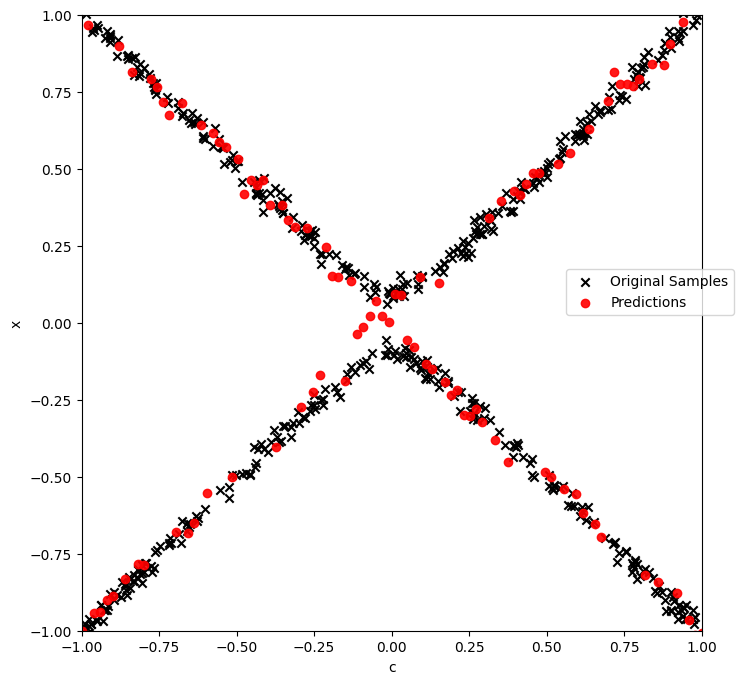


=== Training Run 4 ===
Epoch [1/100], Loss: 0.0987, LR: 0.001000
Epoch [2/100], Loss: 0.0237, LR: 0.001000
Epoch [3/100], Loss: -0.0021, LR: 0.001000
Epoch [4/100], Loss: -0.0428, LR: 0.001000
Epoch [5/100], Loss: -0.0746, LR: 0.001000
Epoch [6/100], Loss: -0.1763, LR: 0.001000
Epoch [7/100], Loss: -0.3743, LR: 0.001000
Epoch [8/100], Loss: -0.6067, LR: 0.001000
Epoch [9/100], Loss: -0.8356, LR: 0.001000
Epoch [10/100], Loss: -1.1254, LR: 0.001000
Epoch [11/100], Loss: -1.2880, LR: 0.001000
Epoch [12/100], Loss: -1.4140, LR: 0.001000
Epoch [13/100], Loss: -1.7038, LR: 0.001000
Epoch [14/100], Loss: -1.8765, LR: 0.001000
Epoch [15/100], Loss: -1.6303, LR: 0.001000
Epoch [16/100], Loss: -1.7899, LR: 0.001000
Epoch [17/100], Loss: -2.0124, LR: 0.001000
Epoch [18/100], Loss: -1.9481, LR: 0.001000
Epoch [19/100], Loss: -1.7305, LR: 0.001000
Epoch [20/100], Loss: -1.9356, LR: 0.000500
Epoch [21/100], Loss: -2.1652, LR: 0.000500
Epoch [22/100], Loss: -2.2678, LR: 0.000500
Epoch [23/100], Los

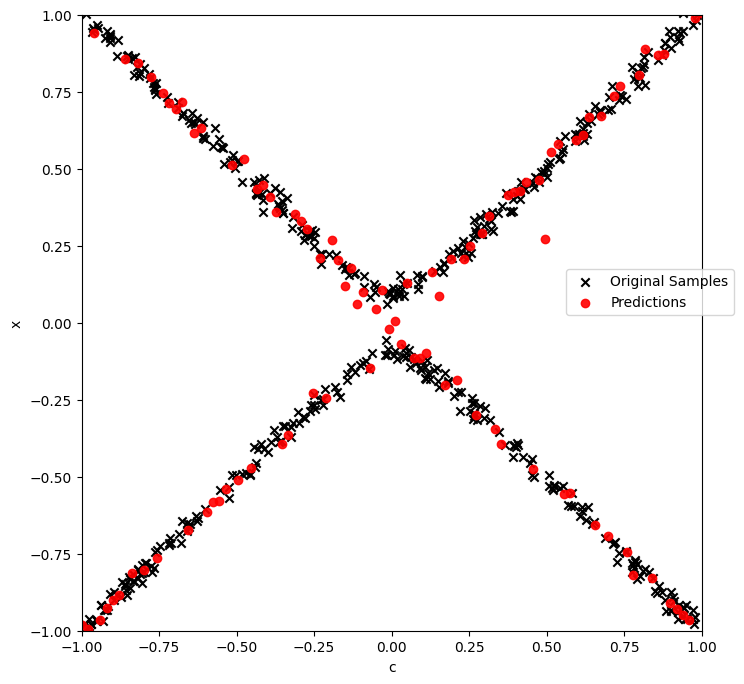


=== Training Run 5 ===
Epoch [1/100], Loss: 0.0903, LR: 0.001000
Epoch [2/100], Loss: 0.0071, LR: 0.001000
Epoch [3/100], Loss: -0.0595, LR: 0.001000
Epoch [4/100], Loss: -0.1936, LR: 0.001000
Epoch [5/100], Loss: -0.3367, LR: 0.001000
Epoch [6/100], Loss: -0.5084, LR: 0.001000
Epoch [7/100], Loss: -0.5763, LR: 0.001000
Epoch [8/100], Loss: -0.6618, LR: 0.001000
Epoch [9/100], Loss: -0.7827, LR: 0.001000
Epoch [10/100], Loss: -0.9412, LR: 0.001000
Epoch [11/100], Loss: -0.8739, LR: 0.001000
Epoch [12/100], Loss: -1.0479, LR: 0.001000
Epoch [13/100], Loss: -1.1113, LR: 0.001000
Epoch [14/100], Loss: -0.9247, LR: 0.001000
Epoch [15/100], Loss: -0.8719, LR: 0.001000
Epoch [16/100], Loss: -1.0560, LR: 0.001000
Epoch [17/100], Loss: -1.0955, LR: 0.001000
Epoch [18/100], Loss: -1.0726, LR: 0.001000
Epoch [19/100], Loss: -1.2727, LR: 0.001000
Epoch [20/100], Loss: -1.4204, LR: 0.000500
Epoch [21/100], Loss: -1.6097, LR: 0.000500
Epoch [22/100], Loss: -1.8493, LR: 0.000500
Epoch [23/100], Los

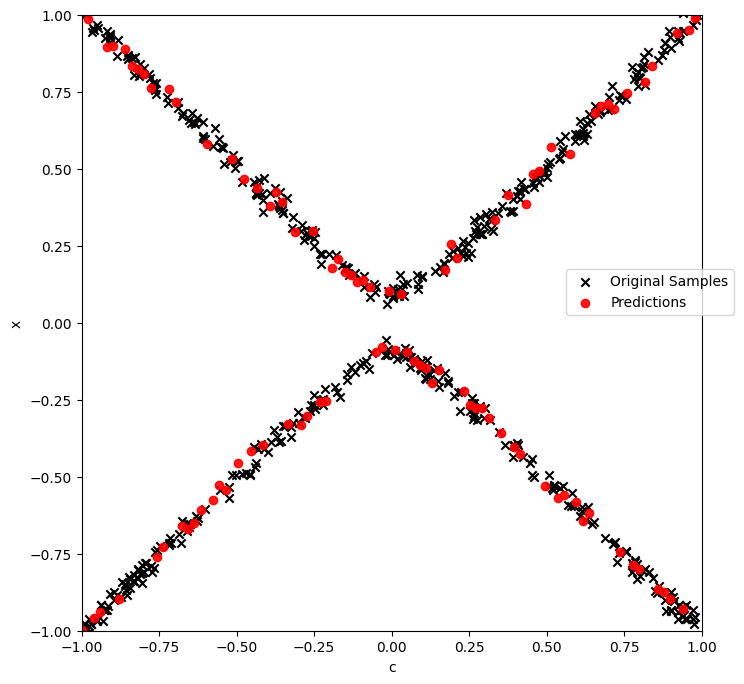

KL Divergence: 2.5148 ± 0.5363
Wasserstein Distance: 0.0088 ± 0.0006
Mode Coverage (%): 99.8000 ± 0.4000
Avgerage Modes coveraged: 1.9980 ± 0.0040


In [34]:
metrics_results = train_and_evaluate_mdn(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_multi = y_multi,
    learning_rate = learning_rate,
    num_gaussians = 3,
    hidden_size = hidden_size
)

## 3. cGAN

In [35]:
# Hyperparameters
hidden_size = 64

num_epochs = 100
batch_size = 32
learning_rate = 0.0002

In [36]:
def visulize_outcomes_gan(generator, discriminator, y_multi, id = 0):
    # Generate grid points within the range of x values
    x_range = np.linspace(-1, 1, 100)
    y_range = np.linspace(-1, 1, 100)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)

    # Compute discriminator output for each grid point
    discriminator_outputs = []
    for point in grid_points:
        x_plot = torch.tensor([point[0]], dtype=torch.float32).unsqueeze(0)
        y_plot = torch.tensor([point[1]], dtype=torch.float32).unsqueeze(0)
        output = discriminator(y_plot, x_plot).detach()
        # output = torch.sigmoid(discriminator(y_plot, x_plot)).detach()
        discriminator_outputs.append(output.item())

    # Reshape the outputs to match the grid
    discriminator_outputs = np.array(discriminator_outputs).reshape(100, 100)
    # Normalize every column of the heatmap
    discriminator_outputs = (discriminator_outputs - discriminator_outputs.min(axis=0)) / (discriminator_outputs.max(axis=0) - discriminator_outputs.min(axis=0))

    # As energy, take minus of the discriminator output
    discriminator_outputs = -discriminator_outputs

    # Plot the heatmap and the function, samples, and predictions in the same figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the heatmap
    heatmap = ax.imshow(discriminator_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.6)
    # cbar = plt.colorbar(heatmap, ax=ax, shrink=0.8)
    
    num_query_points = 100
    query_points = np.linspace(-1, 1, num_query_points)
    query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1)
    z = torch.randn(num_query_points, generator.latent_size)
    predictions = generator(z, query_points_tensor).detach().numpy()


    # Plot the function
    x_vals = np.linspace(-1, 1, 100)
    y_vals = [y_multi(x_i) for x_i in x_vals]
    y_vals_transposed = list(zip(*y_vals))

    for i, y_val in enumerate(y_vals_transposed):
        ax.plot(x_vals, y_val,  linewidth=2)

    # Plot the samples and predictions
    ax.scatter(x, y, marker='x', color='black', label='Original Samples')
    ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.9)

    # Set limits to cut the plot within -1, 1
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_xlabel('c')
    ax.set_ylabel('x')
    ax.grid()
    ax.legend()
    plt.savefig(f'images/cGAN_{id}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [37]:
from methods.cgan import Generator, Discriminator, train
def train_and_evaluate_mdn(num_trials, dataloader, test_x_vals, test_y_vals_transposed, 
                       num_epochs, y_multi, learning_rate, hidden_size, latent_size):
    results = {"KL Divergence": [], "Wasserstein Distance": [], "Mode Coverage (%)": [], "Avgerage Modes coveraged": []}

    for trial in range(num_trials):
        print(f"\n=== Training Run {trial + 1} ===")
        
        # Initialize models
        generator = Generator(latent_size, hidden_size, output_size, condition_size)
        discriminator = Discriminator(output_size, hidden_size, 1, condition_size)

        # Optimizers
        optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
        optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)
        
        # Train
        train(dataloader, generator, discriminator, optimizer_g, optimizer_d, num_epochs, writer = None)

        # Flatten the true test y values for metric computation
        true_y_flat = np.array(test_y_vals_transposed).reshape(-1, len(test_x_vals)).T

        # Compute metrics 
        metrics = compute_metrics(generator, test_x_vals, true_y_flat , y_multi, model = 'Generator', K = 10, num_bins=50, tolerance=TOLERANCE)
        for key in results.keys():
            results[key].append(metrics[key])
            
        print(f"Run {trial + 1} - KL Divergence: {metrics["KL Divergence"]:.4f}, Wasserstein Distance: {metrics["Wasserstein Distance"]:.4f}, Mode Coverage (%): {metrics["Mode Coverage (%)"]}, Avgerage Modes coveraged: {metrics["Avgerage Modes coveraged"]}")
        visulize_outcomes_gan(generator, discriminator, y_multi, trial)
        
    # Compute averages and standard deviations
    for metric, values in results.items():
        avg = np.mean(values)
        std = np.std(values)
        print(f"{metric}: {avg:.4f} ± {std:.4f}")

    return results

### Tests


=== Training Run 1 ===
Epoch [1/100], Discriminator Loss: 1.0169, Generator Loss: 0.9561
Epoch [2/100], Discriminator Loss: 0.8812, Generator Loss: 1.1075
Epoch [3/100], Discriminator Loss: 0.8336, Generator Loss: 1.7902
Epoch [4/100], Discriminator Loss: 0.9355, Generator Loss: 1.7893
Epoch [5/100], Discriminator Loss: 0.9078, Generator Loss: 1.3895
Epoch [6/100], Discriminator Loss: 1.1133, Generator Loss: 1.5563
Epoch [7/100], Discriminator Loss: 1.0024, Generator Loss: 1.5228
Epoch [8/100], Discriminator Loss: 0.6316, Generator Loss: 1.6982
Epoch [9/100], Discriminator Loss: 0.7612, Generator Loss: 1.8324
Epoch [10/100], Discriminator Loss: 0.8895, Generator Loss: 2.0613
Epoch [11/100], Discriminator Loss: 0.6521, Generator Loss: 2.2039
Epoch [12/100], Discriminator Loss: 0.7121, Generator Loss: 2.2464
Epoch [13/100], Discriminator Loss: 0.6437, Generator Loss: 1.8527
Epoch [14/100], Discriminator Loss: 0.7715, Generator Loss: 2.0270
Epoch [15/100], Discriminator Loss: 0.5581, Gen

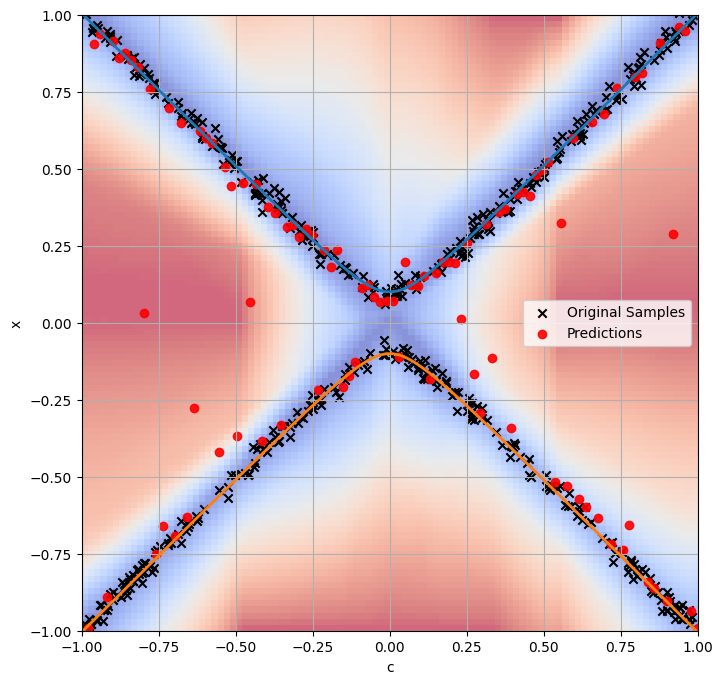


=== Training Run 2 ===
Epoch [1/100], Discriminator Loss: 0.8547, Generator Loss: 1.0555
Epoch [2/100], Discriminator Loss: 0.6156, Generator Loss: 1.4245
Epoch [3/100], Discriminator Loss: 0.5390, Generator Loss: 2.2362
Epoch [4/100], Discriminator Loss: 0.9392, Generator Loss: 2.1171
Epoch [5/100], Discriminator Loss: 1.1244, Generator Loss: 1.4248
Epoch [6/100], Discriminator Loss: 0.7951, Generator Loss: 1.3233
Epoch [7/100], Discriminator Loss: 0.9207, Generator Loss: 1.6362
Epoch [8/100], Discriminator Loss: 0.8427, Generator Loss: 1.1730
Epoch [9/100], Discriminator Loss: 0.9085, Generator Loss: 2.1371
Epoch [10/100], Discriminator Loss: 0.7209, Generator Loss: 1.8128
Epoch [11/100], Discriminator Loss: 0.6322, Generator Loss: 1.5624
Epoch [12/100], Discriminator Loss: 0.6851, Generator Loss: 2.6661
Epoch [13/100], Discriminator Loss: 0.7577, Generator Loss: 1.9823
Epoch [14/100], Discriminator Loss: 0.8777, Generator Loss: 2.2982
Epoch [15/100], Discriminator Loss: 0.6669, Gen

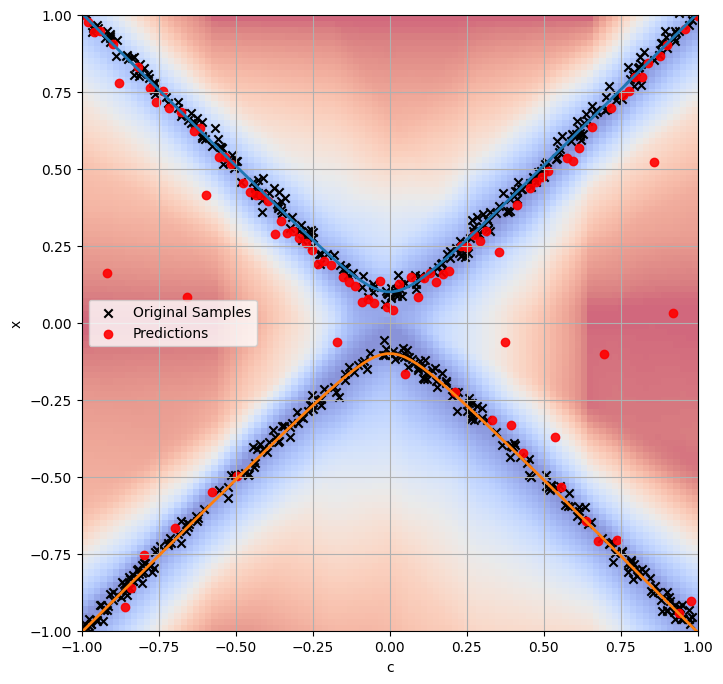


=== Training Run 3 ===
Epoch [1/100], Discriminator Loss: 1.0352, Generator Loss: 0.8900
Epoch [2/100], Discriminator Loss: 0.8422, Generator Loss: 1.2537
Epoch [3/100], Discriminator Loss: 1.0696, Generator Loss: 1.4907
Epoch [4/100], Discriminator Loss: 0.9774, Generator Loss: 1.2860
Epoch [5/100], Discriminator Loss: 1.0249, Generator Loss: 1.1895
Epoch [6/100], Discriminator Loss: 1.0781, Generator Loss: 1.1034
Epoch [7/100], Discriminator Loss: 1.0342, Generator Loss: 1.5343
Epoch [8/100], Discriminator Loss: 0.8784, Generator Loss: 1.4555
Epoch [9/100], Discriminator Loss: 0.8974, Generator Loss: 1.4701
Epoch [10/100], Discriminator Loss: 0.6341, Generator Loss: 1.7110
Epoch [11/100], Discriminator Loss: 0.7879, Generator Loss: 2.1260
Epoch [12/100], Discriminator Loss: 0.6583, Generator Loss: 2.2363
Epoch [13/100], Discriminator Loss: 0.5673, Generator Loss: 2.1011
Epoch [14/100], Discriminator Loss: 0.6133, Generator Loss: 2.3922
Epoch [15/100], Discriminator Loss: 0.7610, Gen

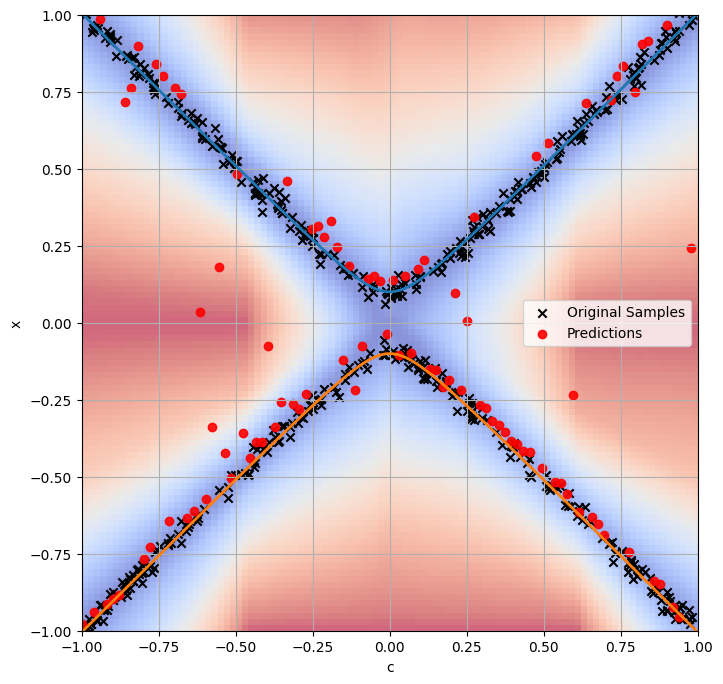


=== Training Run 4 ===
Epoch [1/100], Discriminator Loss: 1.0245, Generator Loss: 0.9020
Epoch [2/100], Discriminator Loss: 0.6312, Generator Loss: 1.5778
Epoch [3/100], Discriminator Loss: 0.5573, Generator Loss: 1.6473
Epoch [4/100], Discriminator Loss: 0.7046, Generator Loss: 1.5859
Epoch [5/100], Discriminator Loss: 0.9382, Generator Loss: 1.1729
Epoch [6/100], Discriminator Loss: 0.7024, Generator Loss: 1.2014
Epoch [7/100], Discriminator Loss: 0.6294, Generator Loss: 2.0083
Epoch [8/100], Discriminator Loss: 0.9057, Generator Loss: 1.7969
Epoch [9/100], Discriminator Loss: 0.6747, Generator Loss: 1.8897
Epoch [10/100], Discriminator Loss: 0.5936, Generator Loss: 2.4695
Epoch [11/100], Discriminator Loss: 1.0903, Generator Loss: 2.0103
Epoch [12/100], Discriminator Loss: 0.6004, Generator Loss: 2.3971
Epoch [13/100], Discriminator Loss: 0.7910, Generator Loss: 1.4747
Epoch [14/100], Discriminator Loss: 0.8199, Generator Loss: 2.2174
Epoch [15/100], Discriminator Loss: 0.6246, Gen

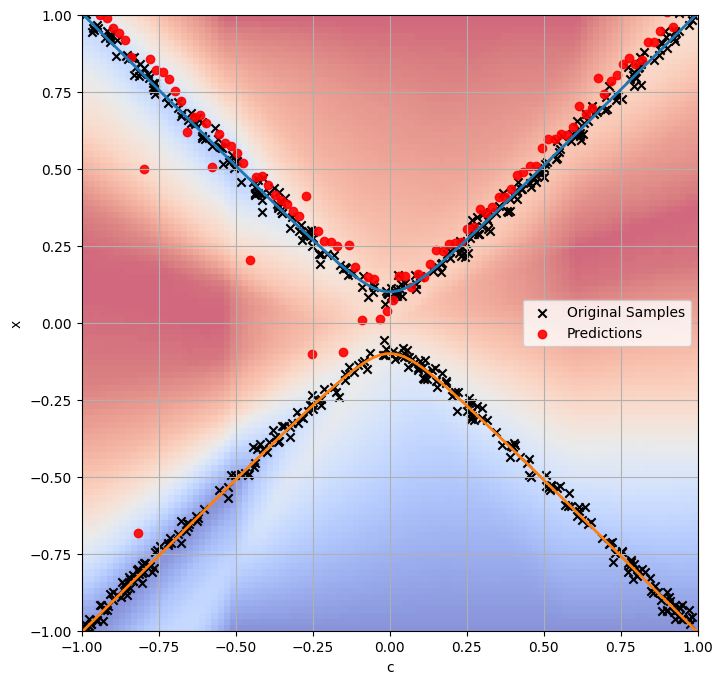


=== Training Run 5 ===
Epoch [1/100], Discriminator Loss: 0.9689, Generator Loss: 0.9884
Epoch [2/100], Discriminator Loss: 0.6627, Generator Loss: 1.5973
Epoch [3/100], Discriminator Loss: 0.9630, Generator Loss: 2.0031
Epoch [4/100], Discriminator Loss: 1.2750, Generator Loss: 1.0921
Epoch [5/100], Discriminator Loss: 1.1321, Generator Loss: 0.8756
Epoch [6/100], Discriminator Loss: 1.1378, Generator Loss: 1.2908
Epoch [7/100], Discriminator Loss: 0.8504, Generator Loss: 1.6269
Epoch [8/100], Discriminator Loss: 0.9368, Generator Loss: 1.2328
Epoch [9/100], Discriminator Loss: 0.8428, Generator Loss: 1.6792
Epoch [10/100], Discriminator Loss: 0.7335, Generator Loss: 1.6979
Epoch [11/100], Discriminator Loss: 0.7029, Generator Loss: 2.1440
Epoch [12/100], Discriminator Loss: 0.6600, Generator Loss: 2.3741
Epoch [13/100], Discriminator Loss: 0.5942, Generator Loss: 2.3290
Epoch [14/100], Discriminator Loss: 0.5116, Generator Loss: 2.5004
Epoch [15/100], Discriminator Loss: 0.8346, Gen

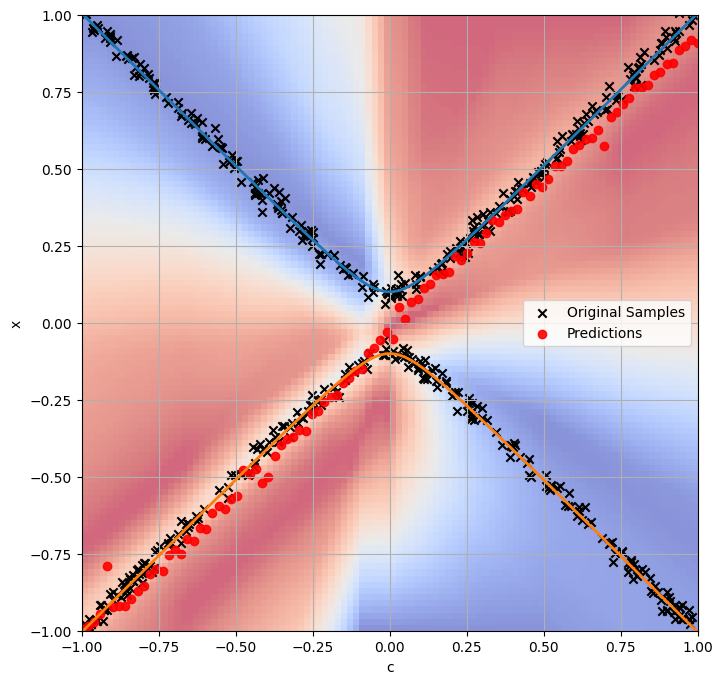

KL Divergence: 3.7245 ± 2.2884
Wasserstein Distance: 0.0098 ± 0.0041
Mode Coverage (%): 55.8000 ± 44.3639
Avgerage Modes coveraged: 1.5580 ± 0.4436


In [38]:
metrics_results = train_and_evaluate_mdn(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_multi = y_multi,
    learning_rate = learning_rate,
    hidden_size = hidden_size,
    latent_size = input_size
)

## 4. EBGAN

In [40]:
hidden_size = 64

num_epochs = 100
batch_size = 32
neg_count = 32
repeat_energy_updates = 5

learning_rate_e = 0.001
learning_rate_g = 0.0005

In [53]:
def visualize_outcome_ebgan(generator, energy_model, y_multi, x, y, device, epoch = None, save_path="visualizations", num_query_points = 100, id = 0):
    # Random sample the query points and get the predictions
    query_points = np.linspace(-1, 1, num_query_points)
    query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1).to(device)

    predictions = []
    for point in query_points:
        query_points_tensor = torch.tensor([[point]], dtype=torch.float32).to(device)
        z = torch.randn(1, generator.latent_size, device=device) 
        prediction = generator(z, query_points_tensor).detach().cpu().numpy()
        predictions.append(prediction.item())


    # Visualize the energy model output heatmap
    # Generate grid points within the range of x values
    x_range = np.linspace(-1, 1, 100)
    y_range = np.linspace(-1, 1, 100)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).to(device)

    # Compute energy model output for each grid point
    energy_outputs = energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()
    energy_outputs = energy_outputs.reshape(100, 100)

    # Normalize every column of the heatmap
    # energy_outputs = (energy_outputs - energy_outputs.min(axis=0)) / (energy_outputs.max(axis=0) - energy_outputs.min(axis=0))
    # Normalize everything of the heatmap
    energy_outputs = (energy_outputs - energy_outputs.min()) / (energy_outputs.max() - energy_outputs.min())


    # Plot the heatmap and the function, samples, and predictions in the same figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the heatmap
    heatmap = ax.imshow(energy_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.6)
    # plt.colorbar(heatmap, ax=ax, label='Energy Model Output')

    # Plot the function
    x_vals = np.linspace(-1, 1, 100)
    y_vals = [y_multi(x_i) for x_i in x_vals]
    y_vals_transposed = list(zip(*y_vals))

    for i, y_val in enumerate(y_vals_transposed):
        ax.plot(x_vals, y_val, linewidth=2)

    # Plot the samples and predictions
    ax.scatter(x, y, marker='x', color='black', label='Original Samples')
    ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.9)

    # Set limits to cut the plot within -1, 1
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_xlabel('c')
    ax.set_ylabel('x')
    ax.grid()
    ax.legend()
    # if epoch: 
    #     ax.set_title(f'Energy-Based Model Predictions in Epoch: {epoch + 1}')
    # else: 
    #     ax.set_title('Energy-Based Model Predictions')
    # plt.savefig('asset/proposal/hyperbola_ebm.png', dpi = 300)
    plt.savefig(f'images/EBGAN{id}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [54]:
from methods.ebgan import Generator, EnergyModel, train
def train_and_evaluate_ebgan(num_trials, dataloader, test_x_vals, test_y_vals_transposed, 
                       num_epochs, y_multi, learning_rate_g, learning_rate_e, hidden_size):
    results = {"KL Divergence": [], "Wasserstein Distance": [], "Mode Coverage (%)": [], "Avgerage Modes coveraged": []}

    for trial in range(num_trials):
        print(f"\n=== Training Run {trial + 1} ===")
        
        # Device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Create models
        generator = Generator(input_size, hidden_size, action_size, condition_size).to(device)
        energy_model = EnergyModel(condition_size, action_size, hidden_size).to(device)

        # Setup optimizers
        optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
        optimizer_e = optim.Adam(energy_model.parameters(), lr=learning_rate_e)
        scheduler_e = optim.lr_scheduler.StepLR(optimizer_e, step_size=20, gamma=0.5)
        scheduler_g = optim.lr_scheduler.StepLR(optimizer_e, step_size=20, gamma=0.5)
        
        # Train
        train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e, scheduler_g,
            num_epochs, None, y_min.to(device), y_max.to(device), neg_count, 
            repeat_energy_updates, device
            )

        # Flatten the true test y values for metric computation
        true_y_flat = np.array(test_y_vals_transposed).reshape(-1, len(test_x_vals)).T

        # Compute metrics 
        metrics = compute_metrics(generator, test_x_vals, true_y_flat , y_multi, model =  'Generator', K = 10, num_bins=50, tolerance=TOLERANCE)
        for key in results.keys():
            results[key].append(metrics[key])
            
        print(f"Run {trial + 1} - KL Divergence: {metrics["KL Divergence"]:.4f}, Wasserstein Distance: {metrics["Wasserstein Distance"]:.4f}, Mode Coverage (%): {metrics["Mode Coverage (%)"]}, Avgerage Modes coveraged: {metrics["Avgerage Modes coveraged"]}")
        visualize_outcome_ebgan(generator, energy_model, y_multi, x, y, device, num_epochs, save_path="visualizations", id = trial)
        
    # Compute averages and standard deviations
    for metric, values in results.items():
        avg = np.mean(values)
        std = np.std(values)
        print(f"{metric}: {avg:.4f} ± {std:.4f}")

    return results

In [ ]:
metrics_results = train_and_evaluate_ebgan(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_multi = y_multi,
    learning_rate_g = learning_rate_g,
    learning_rate_e = learning_rate_e,
    hidden_size = hidden_size
)


=== Training Run 1 ===
Epoch [1/100], Energy Loss: 3.4888, Generator Loss: -0.0061
Epoch [2/100], Energy Loss: 3.2955, Generator Loss: 0.1714
Epoch [3/100], Energy Loss: 2.9702, Generator Loss: 0.4463
Epoch [4/100], Energy Loss: 2.6951, Generator Loss: 0.7091
Epoch [5/100], Energy Loss: 2.5054, Generator Loss: 0.4502
Epoch [6/100], Energy Loss: 2.3847, Generator Loss: 0.2214
Epoch [7/100], Energy Loss: 2.2708, Generator Loss: 0.1208
Epoch [8/100], Energy Loss: 2.2348, Generator Loss: -0.1872
Epoch [9/100], Energy Loss: 2.1686, Generator Loss: -0.2651
Epoch [10/100], Energy Loss: 2.1469, Generator Loss: -0.4392
Epoch [11/100], Energy Loss: 2.1045, Generator Loss: -0.3972
Epoch [12/100], Energy Loss: 2.0850, Generator Loss: -0.0475
Epoch [13/100], Energy Loss: 2.0322, Generator Loss: 0.0720
Epoch [14/100], Energy Loss: 2.0360, Generator Loss: -0.0546
Epoch [15/100], Energy Loss: 1.9890, Generator Loss: -0.1123
Epoch [16/100], Energy Loss: 1.9955, Generator Loss: 0.0375
Epoch [17/100], E

## 5. IBC

In [47]:
# Hyperparameter

hidden_size = 64
num_epochs = 2
batch_size = 32
neg_count = 64
learning_rate = 0.001

In [51]:
def evaluate_model_ibc(energy_model, ebm_infer, id = 0):
    # Random sample the query points and get the predictions
    num_query_points = 100
    query_points = np.linspace(-1, 1, num_query_points)

    predictions = []
    for point in query_points:
        query_points_tensor = torch.tensor([[point]], dtype=torch.float32).to(device)
        prediction = ebm_infer(energy_model, query_points_tensor, y_min.to(device), y_max.to(device))
        predictions.append(prediction.item())


    # Visualize the energy model output heatmap
    # Generate grid points within the range of x values
    x_range = np.linspace(-1, 1, 100)
    y_range = np.linspace(-1, 1, 100)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).to(device)

    # Compute energy model output for each grid point
    energy_outputs = energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()
    energy_outputs = energy_outputs.reshape(100, 100)

    # Normalize every column of the heatmap
    energy_outputs = (energy_outputs - energy_outputs.min(axis=0)) / (energy_outputs.max(axis=0) - energy_outputs.min(axis=0))

    # Plot the heatmap and the function, samples, and predictions in the same figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the heatmap
    heatmap = ax.imshow(energy_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.6)
    # plt.colorbar(heatmap, ax=ax, label='Energy Model Output')

    # Plot the function
    x_vals = np.linspace(-1, 1, 100)
    y_vals = [y_multi(x_i) for x_i in x_vals]
    y_vals_transposed = list(zip(*y_vals))

    for i, y_val in enumerate(y_vals_transposed):
        ax.plot(x_vals, y_val, linewidth=2)

    # Plot the samples and predictions
    ax.scatter(x, y, marker='x', color='black', label='Original Samples')
    ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.9)

    # Set limits to cut the plot within -1, 1
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_xlabel('c')
    ax.set_ylabel('x')
    ax.grid()
    ax.legend()
    # plt.savefig('asset/proposal/hyperbola_ebm.png', dpi = 300)
    plt.savefig(f'images/IBC_{id}.png', dpi=300, bbox_inches='tight')
    plt.show()


In [52]:
from methods.ibc import EnergyModel, train, ebm_infer, info_nce_loss

def train_and_evaluate_ibc(num_trials, dataloader, test_x_vals, test_y_vals_transposed, 
                       num_epochs, y_multi, learning_rate, hidden_size, ebm_infer, info_nce_loss):
    results = {"KL Divergence": [], "Wasserstein Distance": [], "Mode Coverage (%)": [], "Avgerage Modes coveraged": []}

    for trial in range(num_trials):
        print(f"\n=== Training Run {trial + 1} ===")
        
        model = EnergyModel(input_size, action_size, hidden_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
        
        # Train
        train(model, dataloader, info_nce_loss, optimizer, scheduler, num_epochs, None, y_min.to(device), y_max.to(device), neg_count, device)

        # Flatten the true test y values for metric computation
        true_y_flat = np.array(test_y_vals_transposed).reshape(-1, len(test_x_vals)).T

        # Compute metrics 
        metrics = compute_metrics(model, test_x_vals, true_y_flat , y_multi, model =  'IBC', K = 10, num_bins=50, tolerance=TOLERANCE)
        for key in results.keys():
            results[key].append(metrics[key])
            
        print(f"Run {trial + 1} - KL Divergence: {metrics["KL Divergence"]:.4f}, Wasserstein Distance: {metrics["Wasserstein Distance"]:.4f}, Mode Coverage (%): {metrics["Mode Coverage (%)"]}, Avgerage Modes coveraged: {metrics["Avgerage Modes coveraged"]}")
        evaluate_model_ibc(model, ebm_infer, trial)
        
    # Compute averages and standard deviations
    for metric, values in results.items():
        avg = np.mean(values)
        std = np.std(values)
        print(f"{metric}: {avg:.4f} ± {std:.4f}")

    return results

In [55]:
metrics_results = train_and_evaluate_ibc(
    num_trials=NUM_TRIALS,
    dataloader=dataloader,
    test_x_vals=test_x_vals,
    test_y_vals_transposed=test_y_vals_transposed,
    num_epochs=num_epochs,
    y_multi = y_multi,
    learning_rate = learning_rate,
    hidden_size = hidden_size,
    ebm_infer = ebm_infer,
    info_nce_loss = info_nce_loss
)


=== Training Run 1 ===
Epoch [1/2], Loss: 4.1631, LR: 0.001000
Epoch [2/2], Loss: 4.1357, LR: 0.001000
[tensor([[-0.3203]]), tensor([[0.2203]]), tensor([[-1.]]), tensor([[-0.9567]]), tensor([[-0.9274]]), tensor([[0.7485]]), tensor([[-0.5086]]), tensor([[-0.9672]]), tensor([[0.4021]]), tensor([[0.8404]])]
[tensor([[-0.4331]]), tensor([[-0.9387]]), tensor([[-1.]]), tensor([[0.6729]]), tensor([[-0.7608]]), tensor([[0.4329]]), tensor([[-0.5179]]), tensor([[0.7858]]), tensor([[-0.7559]]), tensor([[0.5340]])]
[tensor([[-0.1323]]), tensor([[0.8369]]), tensor([[-0.8119]]), tensor([[-1.]]), tensor([[0.4349]]), tensor([[-0.2191]]), tensor([[-0.9462]]), tensor([[0.0041]]), tensor([[-1.]]), tensor([[0.5646]])]
[tensor([[-0.3112]]), tensor([[-0.8999]]), tensor([[0.6579]]), tensor([[-0.0211]]), tensor([[-0.4292]]), tensor([[-0.4414]]), tensor([[-0.9862]]), tensor([[0.1308]]), tensor([[-0.2668]]), tensor([[-0.3615]])]
[tensor([[-0.6246]]), tensor([[0.5021]]), tensor([[-0.1030]]), tensor([[-0.5737]])

KeyboardInterrupt: 